In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#model Training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, cross_val_score

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model

from sklearn.metrics import mean_squared_error

#knn imputer
from sklearn.neighbors import KNeighborsRegressor

#feature filtering/processing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestClassifier

#outliers
from sklearn.ensemble import IsolationForest

#plot tree
from sklearn.tree import plot_tree

#sns configuration
sns.set(style="ticks", color_codes=True)

#investigate data
pd.set_option('display.max_columns', None)

#dictionary
import collections

#display dataframe
from IPython.display import display

#hyperparameters tuning
from scipy.stats import loguniform
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import statsmodels.regression.linear_model as smrlm
import statsmodels.api as sm
from scipy.stats import randint

#scoring
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


import math

from graph_utils import *
from utils import *

# Knowledge

1. Fetus = which fetus is it (first fetus, second fetus)

In [2]:
#read csv
df_1112 = pd.read_excel('data/FGR_STUDY 20112012.xls', header=2)
df_1213 = pd.read_excel('data/FGR_STUDY 20122013.xls', header=2)
df_1314 = pd.read_excel('data/FGR_STUDY 20132014.xls', header=2)
df_1415 = pd.read_excel('data/FGR_STUDY 20142015.xls', header=2)
df_1516 = pd.read_excel('data/FGR_STUDY 20152016.xls', header=2)
df_1617 = pd.read_excel('data/FGR_STUDY 20162017.xls', header=2)
df_1718 = pd.read_excel('data/FGR_STUDY 20172018.xls', header=2)
df_1819 = pd.read_excel('data/FGR_STUDY 20182019.xls', header=2)
df_1920 = pd.read_excel('data/FGR_STUDY 20192020.xls', header=2)
df_2021 = pd.read_excel('data/FGR_STUDY 20202021.xls', header=2)

In [3]:
print(f'Rows of df_1112: {df_1112.shape[0]}')
print(f'Rows of df_1213: {df_1213.shape[0]}')
print(f'Rows of df_1314: {df_1314.shape[0]}')
print(f'Rows of df_1415: {df_1415.shape[0]}')
print(f'Rows of df_1516: {df_1516.shape[0]}')
print(f'Rows of df_1617: {df_1617.shape[0]}')
print(f'Rows of df_1718: {df_1718.shape[0]}')
print(f'Rows of df_1819: {df_1819.shape[0]}')
print(f'Rows of df_1920: {df_1920.shape[0]}')
print(f'Rows of df_2021: {df_2021.shape[0]}')

print(f'Total Rows: {df_1112.shape[0] + df_1213.shape[0] + df_1314.shape[0] + df_1415.shape[0] + df_1516.shape[0]+df_1617.shape[0] + df_1718.shape[0] + df_1819.shape[0] + df_1920.shape[0] + df_2021.shape[0]}')

Rows of df_1112: 6
Rows of df_1213: 7400
Rows of df_1314: 13300
Rows of df_1415: 14550
Rows of df_1516: 16701
Rows of df_1617: 16912
Rows of df_1718: 19078
Rows of df_1819: 21433
Rows of df_1920: 18078
Rows of df_2021: 16785
Total Rows: 144243


In [4]:
df_2021 = df_2021.rename(columns={'GA (WK)': ' (2)', 'GA (DAYS)': ' (3)'})

In [5]:
frames = [df_1112, df_1213, df_1314, df_1415, df_1516, df_1617, df_1718, df_1819, df_1920, df_2021]
df_master = pd.concat(frames)

In [6]:
#(2) is Gweek, (3) is Gday (I guess)
df_master['GA(day)'] = df_master[' (2)'] * 7 + df_master[' (3)']
df_master['GA(week)'] = df_master['GA(day)'] // 7

In [7]:
#drop some unecessary columns
df_master = df_master.drop([' (2)', ' (3)'], axis=1)

In [8]:
df_master = df_master[~df_master['EFW (clinical)'].isnull()]

In [9]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96510 entries, 0 to 16784
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   PID                       96510 non-null  int64         
 1   Case number               96510 non-null  int64         
 2   Exam                      96510 non-null  int64         
 3   Fetus                     96510 non-null  float64       
 4   Hospital no.              96510 non-null  object        
 5   Ethnic_group              265 non-null    object        
 6   BPD                       96348 non-null  float64       
 7   HC                        96468 non-null  float64       
 8   TCD                       25859 non-null  float64       
 9   AC                        96499 non-null  float64       
 10  CM                        21435 non-null  float64       
 11  FL                        96492 non-null  float64       
 12  Humerus           

## Personal Preprocessing

1. Removing features with <1000 non-null :
    - 4   Ethnic_group              265 non-null    object  
    - 26  A-wave                    359 non-null    object        
    - 27  Ductus Venosus PI         135 non-null    float64       
    - 28  TAV                       14 non-null     float64       
    - 29  Uterine artery PI  left   107 non-null    float64       
    - 30  Uterine artery PI  right  116 non-null    float64       
    - 31  RI left                   97 non-null     float64       
    - 32  RI right                  107 non-null    float64       
    - 33  Notch                     87 non-null     object        
    - 34  Funnelling                384 non-null    object        
    - 35  Cervix length             426 non-null    float64  
 
2. Correcting dtypes of:
    - Fetus                     96510 non-null  float64 >> int32
    - Presentation              95572 non-null  object >> category  
    - Placenta site             94756 non-null  object >> category  
    - Amniotic fluid            94511 non-null  object >> category
    - Cord                      34048 non-null  object >> category    
    
3. Remove fetus 2 (we only focus on singleton pregnancies)

In [10]:
#dropping mostly missing features
# df_master = df_master.drop(['Ethnic_group', 'A-wave', 'Ductus Venosus PI', 'TAV',
#                             'Uterine artery PI  left', 'Uterine artery PI  right', 'RI left',
#                             'RI right', 'Notch', 'Funnelling', 'Cervix length',], axis=1)

#correcting dtypes
df_master['Fetus'] = df_master['Fetus'].astype('int32')
df_master['Presentation'] = df_master['Presentation'].astype('category')
df_master['Placenta site'] = df_master['Placenta site'].astype('category')
df_master['Amniotic fluid'] = df_master['Amniotic fluid'].astype('category')
df_master['Cord'] = df_master['Cord'].astype('category')

#removing fetus>1 mothers
patient_remove = list(df_master[df_master['Fetus'] > 1]['Hospital no.'].unique())
df_master = df_master[~df_master['Hospital no.'].isin(patient_remove)]

In [11]:
df_master.shape

(89397, 45)

# Split into 3 seperate dataframe

Retrieved from 374 patients in previous df: 

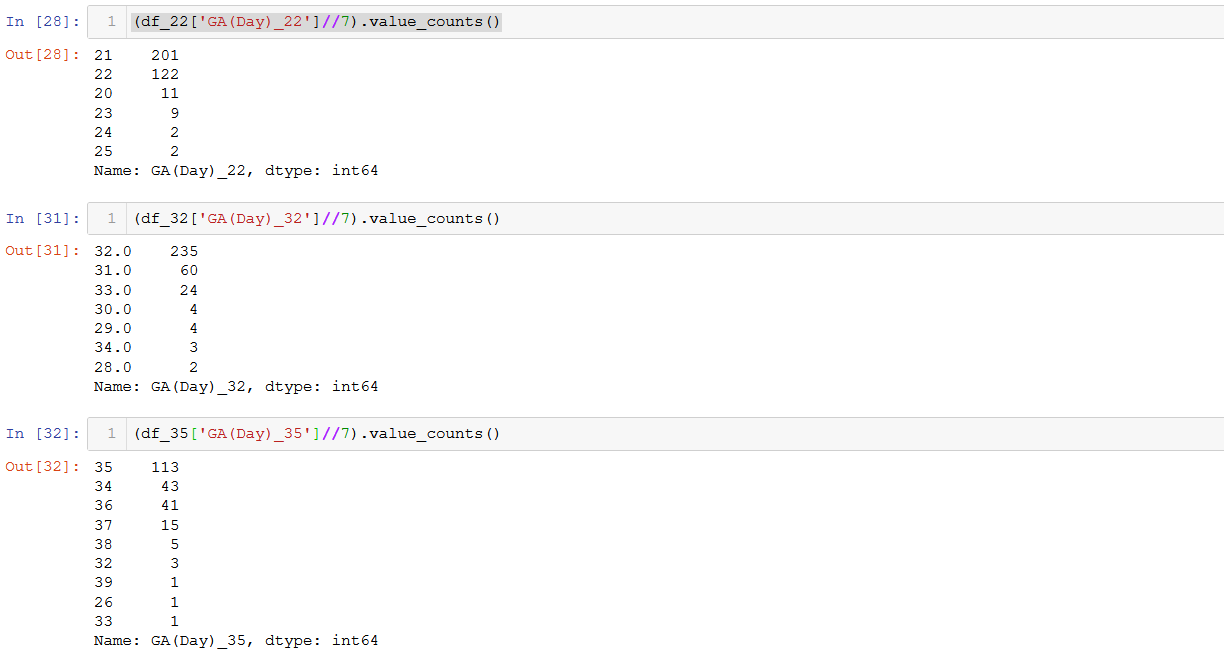

Basically:
1. Wk22 = <28 || Wk32 = 28 - 34 || Wk35 = >34
- get common hospital no. from each df, then filter.
- A patient not necessary has only 1 scan in each wk. - my idea here is that it's okay to more scan, because it will be used to forecast the same value in the other wk anyways.
    - So I think that the GA(week) of the forecasted week need to be an input of the model.
    - by using merge:
        - Let say patient A has 2 row of records in both wk22 and wk32. This will create 4 rows (each row in wk22 associated with each row in wk32)


In [12]:
def get_cat(week):
    '''
    Wk22 = <28 Wk32 = 28 - 34 Wk35 = >34
    '''
    
    if week < 28:
        return 'wk22'
    elif week > 34:
        return 'wk35'
    else:
        return 'wk32'

df_master['df_cat'] = df_master['GA(week)'].apply(lambda x: get_cat(x))

In [13]:
df_master

,PID,Case number,Exam,Fetus,Hospital no.,Ethnic_group,BPD,HC,TCD,AC,CM,FL,Humerus,EFW (clinical),EFW centile,Fetal heart rate,Presentation,Placenta site,AF Index,Amniotic fluid,Cord,PI,RI,EDF,PI (2),RI (2),Cerebro-placental ratio,A-wave,Ductus Venosus PI,TAV,Uterine artery PI left,Uterine artery PI right,RI left,RI right,Notch,Funnelling,Cervix length,Estimated fetal weight,Examination date,UA PI,UA RI,MCA PI (2),MCA RI (2),GA(day),GA(week),df_cat
0,8,1,1,1,25208098,Malay,83.7,285.0,NaN,292.3,NaN,60.0,55.5,1984.0,21.4,NaN,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-10,NaN,NaN,NaN,NaN,234.0,33.0,wk32
5,16,1,1,1,31146923,NaN,46.8,168.6,21.4,156.1,5.1,32.5,NaN,350.0,NaN,NaN,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,149.0,21.0,wk22
6,17,1,1,1,04841360,NaN,82.9,309.2,NaN,290.8,NaN,64.4,NaN,2164.0,7.4,NaN,cephalic,posterior high,10.5,normal,NaN,0.86,0.59,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,249.0,35.0,wk35
7,19,1,1,1,31159261,NaN,88.8,319.4,NaN,298.4,NaN,61.4,NaN,2249.0,15.3,NaN,cephalic,anterior high,8.8,normal,NaN,0.66,0.49,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,246.0,35.0,wk35
10,23,1,1,1,31173766,NaN,50.5,195.7,21.6,168.4,7.9,37.1,NaN,452.0,NaN,NaN,breech,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,155.0,22.0,wk22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16773,43836,1,1,1,34500839,NaN,52.3,195.2,24.9,178.9,4.7,37.2,NaN,490.0,NaN,NaN,breech,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-05-05,NaN,NaN,NaN,NaN,156.0,22.0,wk22
16778,43840,1,2,1,36157691,NaN,71.0,255.6,NaN,236.6,NaN,52.4,NaN,1154.0,6.3,NaN,cephalic,posterior high,10.3,normal,NaN,NaN,NaN,positive,NaN,NaN,1.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-05-18,1.14,0.69,1.46,0.75,210.0,30.0,wk32
16779,43840,1,1,1,36157691,NaN,68.5,247.8,NaN,217.5,NaN,46.0,NaN,882.0,7.4,NaN,cephalic,posterior high,10.0,normal,NaN,NaN,NaN,positive,NaN,NaN,1.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-05-05,1.13,0.67,1.60,0.85,197.0,28.0,wk32
16782,43843,1,1,1,35146320,NaN,62.8,229.1,28.8,204.1,7.8,46.2,42.1,776.0,26.7,148.0,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-05-06,NaN,NaN,NaN,NaN,181.0,25.0,wk22


In [14]:
df_new = df_master.groupby('df_cat')  
df_22 = df_new.get_group('wk22')
df_32 = df_new.get_group('wk32')
df_35 = df_new.get_group('wk35')

In [15]:
df_35.shape

(31658, 46)

In [16]:
no_22 = set(df_22['Hospital no.'].unique())
no_32 = set(df_32['Hospital no.'].unique())
no_35 = set(df_35['Hospital no.'].unique())

In [17]:
common_no = no_22.intersection(no_32).intersection(no_35)

In [18]:
df_32[df_32['Hospital no.'].isin(common_no)].sort_values(['Hospital no.', 'Examination date'], ascending=[True, True])

,PID,Case number,Exam,Fetus,Hospital no.,Ethnic_group,BPD,HC,TCD,AC,CM,FL,Humerus,EFW (clinical),EFW centile,Fetal heart rate,Presentation,Placenta site,AF Index,Amniotic fluid,Cord,PI,RI,EDF,PI (2),RI (2),Cerebro-placental ratio,A-wave,Ductus Venosus PI,TAV,Uterine artery PI left,Uterine artery PI right,RI left,RI right,Notch,Funnelling,Cervix length,Estimated fetal weight,Examination date,UA PI,UA RI,MCA PI (2),MCA RI (2),GA(day),GA(week),df_cat
13122,19636,1,4,1,01036335,NaN,70.1,266.1,NaN,245.4,NaN,52.2,NaN,1228.0,40.5,NaN,cephalic,anterior high,12.3,normal,NaN,0.93,0.62,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2016-03-29,NaN,NaN,NaN,NaN,202.0,28.0,wk32
13120,19636,1,5,1,01036335,NaN,76.5,287.6,NaN,282.1,NaN,61.3,NaN,1864.0,46.4,NaN,cephalic,anterior high,12.4,normal,NaN,0.82,0.57,positive,1.76,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,33.0,Hadlock (BPD-HC-AC-FL),2016-04-19,NaN,NaN,NaN,NaN,223.0,31.0,wk32
2697,11013,1,2,1,01059564,NaN,73.6,264.7,NaN,246.3,NaN,50.7,NaN,1214.0,48.1,NaN,Variable,posterior high,28.0,polyhydramnios,NaN,1.34,0.75,NaN,2.15,0.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2014-07-08,NaN,NaN,NaN,NaN,200.0,28.0,wk32
2696,11013,1,3,1,01059564,NaN,84.7,304.0,NaN,295.3,NaN,61.8,NaN,2136.0,62.0,NaN,cephalic,posterior high,29.4,polyhydramnios,NaN,1.05,0.68,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2014-08-05,NaN,NaN,NaN,NaN,228.0,32.0,wk32
3298,1630,1,2,1,01067818,NaN,81.6,301.4,NaN,282.9,NaN,66.6,NaN,2110.0,27.6,NaN,cephalic,Placenta praevia,14.7,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2013-01-29,NaN,NaN,NaN,NaN,236.0,33.0,wk32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16131,43097,1,2,1,36060333,NaN,87.8,312.1,NaN,315.3,NaN,65.6,NaN,2559.0,86.2,NaN,cephalic,anterior high,16.0,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-03-15,NaN,NaN,NaN,NaN,233.0,33.0,wk32
14641,43461,1,2,1,36066718,NaN,71.2,257.3,NaN,238.2,NaN,53.4,NaN,1191.0,24.6,NaN,cephalic,anterior high,NaN,normal,NaN,NaN,NaN,positive,NaN,NaN,1.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-04-07,0.91,0.62,1.75,0.79,204.0,29.0,wk32
14642,43461,1,3,1,36066718,NaN,76.6,276.5,NaN,248.3,NaN,56.7,53.1,1408.0,14.3,NaN,cephalic,anterior high,10.6,normal,3 vessels,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-04-19,0.99,0.63,NaN,NaN,216.0,30.0,wk32
14431,43391,1,2,1,36067895,NaN,84.5,313.4,NaN,299.2,NaN,56.0,53.6,2045.0,21.6,NaN,cephalic,posterior high,7.1,reduced,NaN,NaN,NaN,positive,NaN,NaN,2.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-04-26,0.65,0.49,1.52,NaN,236.0,33.0,wk32


In [19]:
df_22[df_22['Hospital no.'].isin(common_no)].sort_values(['Hospital no.', 'Examination date'], ascending=[True, True])

,PID,Case number,Exam,Fetus,Hospital no.,Ethnic_group,BPD,HC,TCD,AC,CM,FL,Humerus,EFW (clinical),EFW centile,Fetal heart rate,Presentation,Placenta site,AF Index,Amniotic fluid,Cord,PI,RI,EDF,PI (2),RI (2),Cerebro-placental ratio,A-wave,Ductus Venosus PI,TAV,Uterine artery PI left,Uterine artery PI right,RI left,RI right,Notch,Funnelling,Cervix length,Estimated fetal weight,Examination date,UA PI,UA RI,MCA PI (2),MCA RI (2),GA(day),GA(week),df_cat
13123,19636,1,2,1,01036335,NaN,46.6,173.5,20.5,161.8,2.4,34.8,NaN,390.0,NaN,NaN,transverse,anterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.74,NaN,0.5,no notch,NaN,NaN,Hadlock (BPD-HC-AC-FL),2016-02-02,NaN,NaN,NaN,NaN,146.0,20.0,wk22
13118,19636,1,3,1,01036335,NaN,59.5,230.4,NaN,198.7,NaN,44.7,NaN,719.0,29.6,NaN,transverse,anterior low,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2016-03-01,NaN,NaN,NaN,NaN,174.0,24.0,wk22
2698,11013,1,1,1,01059564,NaN,50.7,187.4,21.4,151.4,4.3,36.9,35.6,393.0,NaN,NaN,cephalic,posterior low,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2014-05-21,NaN,NaN,NaN,NaN,152.0,21.0,wk22
2000,1630,1,1,1,01067818,NaN,63.3,250.8,NaN,214.5,NaN,48.3,NaN,897.0,36.2,NaN,cephalic,posterior low,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-12-11,NaN,NaN,NaN,NaN,187.0,26.0,wk22
9225,12763,1,1,1,01080296,NaN,51.4,190.0,NaN,170.0,NaN,38.4,NaN,469.0,NaN,NaN,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2014-09-17,NaN,NaN,NaN,NaN,151.0,21.0,wk22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16223,43200,1,1,1,36054730,NaN,51.3,192.4,23.7,184.0,5.8,39.7,36.2,536.0,NaN,150.0,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-02-16,NaN,NaN,NaN,NaN,163.0,23.0,wk22
16133,43097,1,1,1,36060333,NaN,72.7,272.6,NaN,249.1,NaN,51.0,47.4,1252.0,87.5,NaN,transverse,anterior high,24.0,increased,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-02-03,NaN,NaN,NaN,NaN,193.0,27.0,wk22
14643,43461,1,1,1,36066718,NaN,64.2,235.3,31.1,215.3,4.3,50.1,NaN,918.0,37.7,NaN,cephalic,anterior high,NaN,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,26.0,Hadlock (BPD-HC-AC-FL),2021-03-22,NaN,NaN,NaN,NaN,188.0,26.0,wk22
14433,43391,1,1,1,36067895,NaN,69.1,255.4,34.5,247.0,NaN,49.6,NaN,1160.0,68.0,NaN,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-03-15,NaN,NaN,NaN,NaN,194.0,27.0,wk22


# Visualization

In [20]:
def visualize_val_edit(value_cols, df_22, df_32, df_35):
    
    df_22['df'] = 'df_22'
    df_32['df'] = 'df_32'
    df_35['df'] = 'df_35'
    
    df_master = pd.concat([df_22, df_32, df_35])
    
    fig, ax = plt.subplots(len(value_cols), figsize=(15,35))
    fig.subplots_adjust(top=2)
    for index, col in enumerate(value_cols):
        sns.set_palette('flare')
        a = sns.boxplot(x=col, y='df', data=df_master, ax=ax[index])
        a.set_xlabel('', fontsize = 20.0) # X label
        a.set_ylabel(col, fontsize=15.0)
        a.tick_params(labelsize=20.0)

    fig.tight_layout()
    plt.show()

def visualize_cat(cols, df_22, df_32, df_35):
    '''visulizing categorical data'''
    
    df_22['df'] = 'df_22'
    df_32['df'] = 'df_32'
    df_35['df'] = 'df_35'
    
    df_master = pd.concat([df_22, df_32, df_35])
    
    fig, ax = plt.subplots(len(cols), figsize=(15,35))

    for index, col in enumerate(cat_cols):
        sns.set_palette("pastel")
        b = sns.countplot(y=col, data=df_master, ax=ax[index], hue='df')
        b.set_xlabel('', fontsize = 15.0) # X label
        b.set_ylabel(col, fontsize = 20.0) # Y label
        b.tick_params(labelsize=20)

    fig.tight_layout()
    plt.show()

sns.set_palette('flare')
value_cols = df_master.select_dtypes(include=['float64']).columns
cat_cols = df_master.select_dtypes(include=['category']).columns

In [21]:
df_22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26603 entries, 5 to 16782
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   PID                       26603 non-null  int64         
 1   Case number               26603 non-null  int64         
 2   Exam                      26603 non-null  int64         
 3   Fetus                     26603 non-null  int32         
 4   Hospital no.              26603 non-null  object        
 5   Ethnic_group              77 non-null     object        
 6   BPD                       26585 non-null  float64       
 7   HC                        26588 non-null  float64       
 8   TCD                       21012 non-null  float64       
 9   AC                        26602 non-null  float64       
 10  CM                        19623 non-null  float64       
 11  FL                        26601 non-null  float64       
 12  Humerus           

In [249]:
df_22.head()

,PID,Case number,Exam,Fetus,Hospital no.,Ethnic_group,BPD,HC,TCD,AC,CM,FL,Humerus,EFW (clinical),EFW centile,Fetal heart rate,Presentation,Placenta site,AF Index,Amniotic fluid,Cord,PI,RI,EDF,PI (2),RI (2),Cerebro-placental ratio,A-wave,Ductus Venosus PI,TAV,Uterine artery PI left,Uterine artery PI right,RI left,RI right,Notch,Funnelling,Cervix length,Estimated fetal weight,Examination date,UA PI,UA RI,MCA PI (2),MCA RI (2),GA(day),GA(week),df_cat
5,16,1,1,1,31146923,NaN,46.8,168.6,21.4,156.1,5.1,32.5,NaN,350.0,NaN,NaN,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,149.0,21.0,wk22
10,23,1,1,1,31173766,NaN,50.5,195.7,21.6,168.4,7.9,37.1,NaN,452.0,NaN,NaN,breech,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,155.0,22.0,wk22
18,30,1,1,1,29779790,NaN,50.7,191.7,23.3,168.6,4.2,37.9,NaN,459.0,NaN,NaN,Extended breech,anterior high,NaN,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,155.0,22.0,wk22
22,34,1,1,1,27591077,NaN,46.8,175.1,22.2,151.6,5.1,32.4,NaN,340.0,NaN,NaN,breech,fundal,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,145.0,20.0,wk22
27,38,1,1,1,12350378,NaN,51.2,190.7,22.1,163.8,6.0,34.8,NaN,410.0,NaN,NaN,Extended breech,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,142.0,20.0,wk22


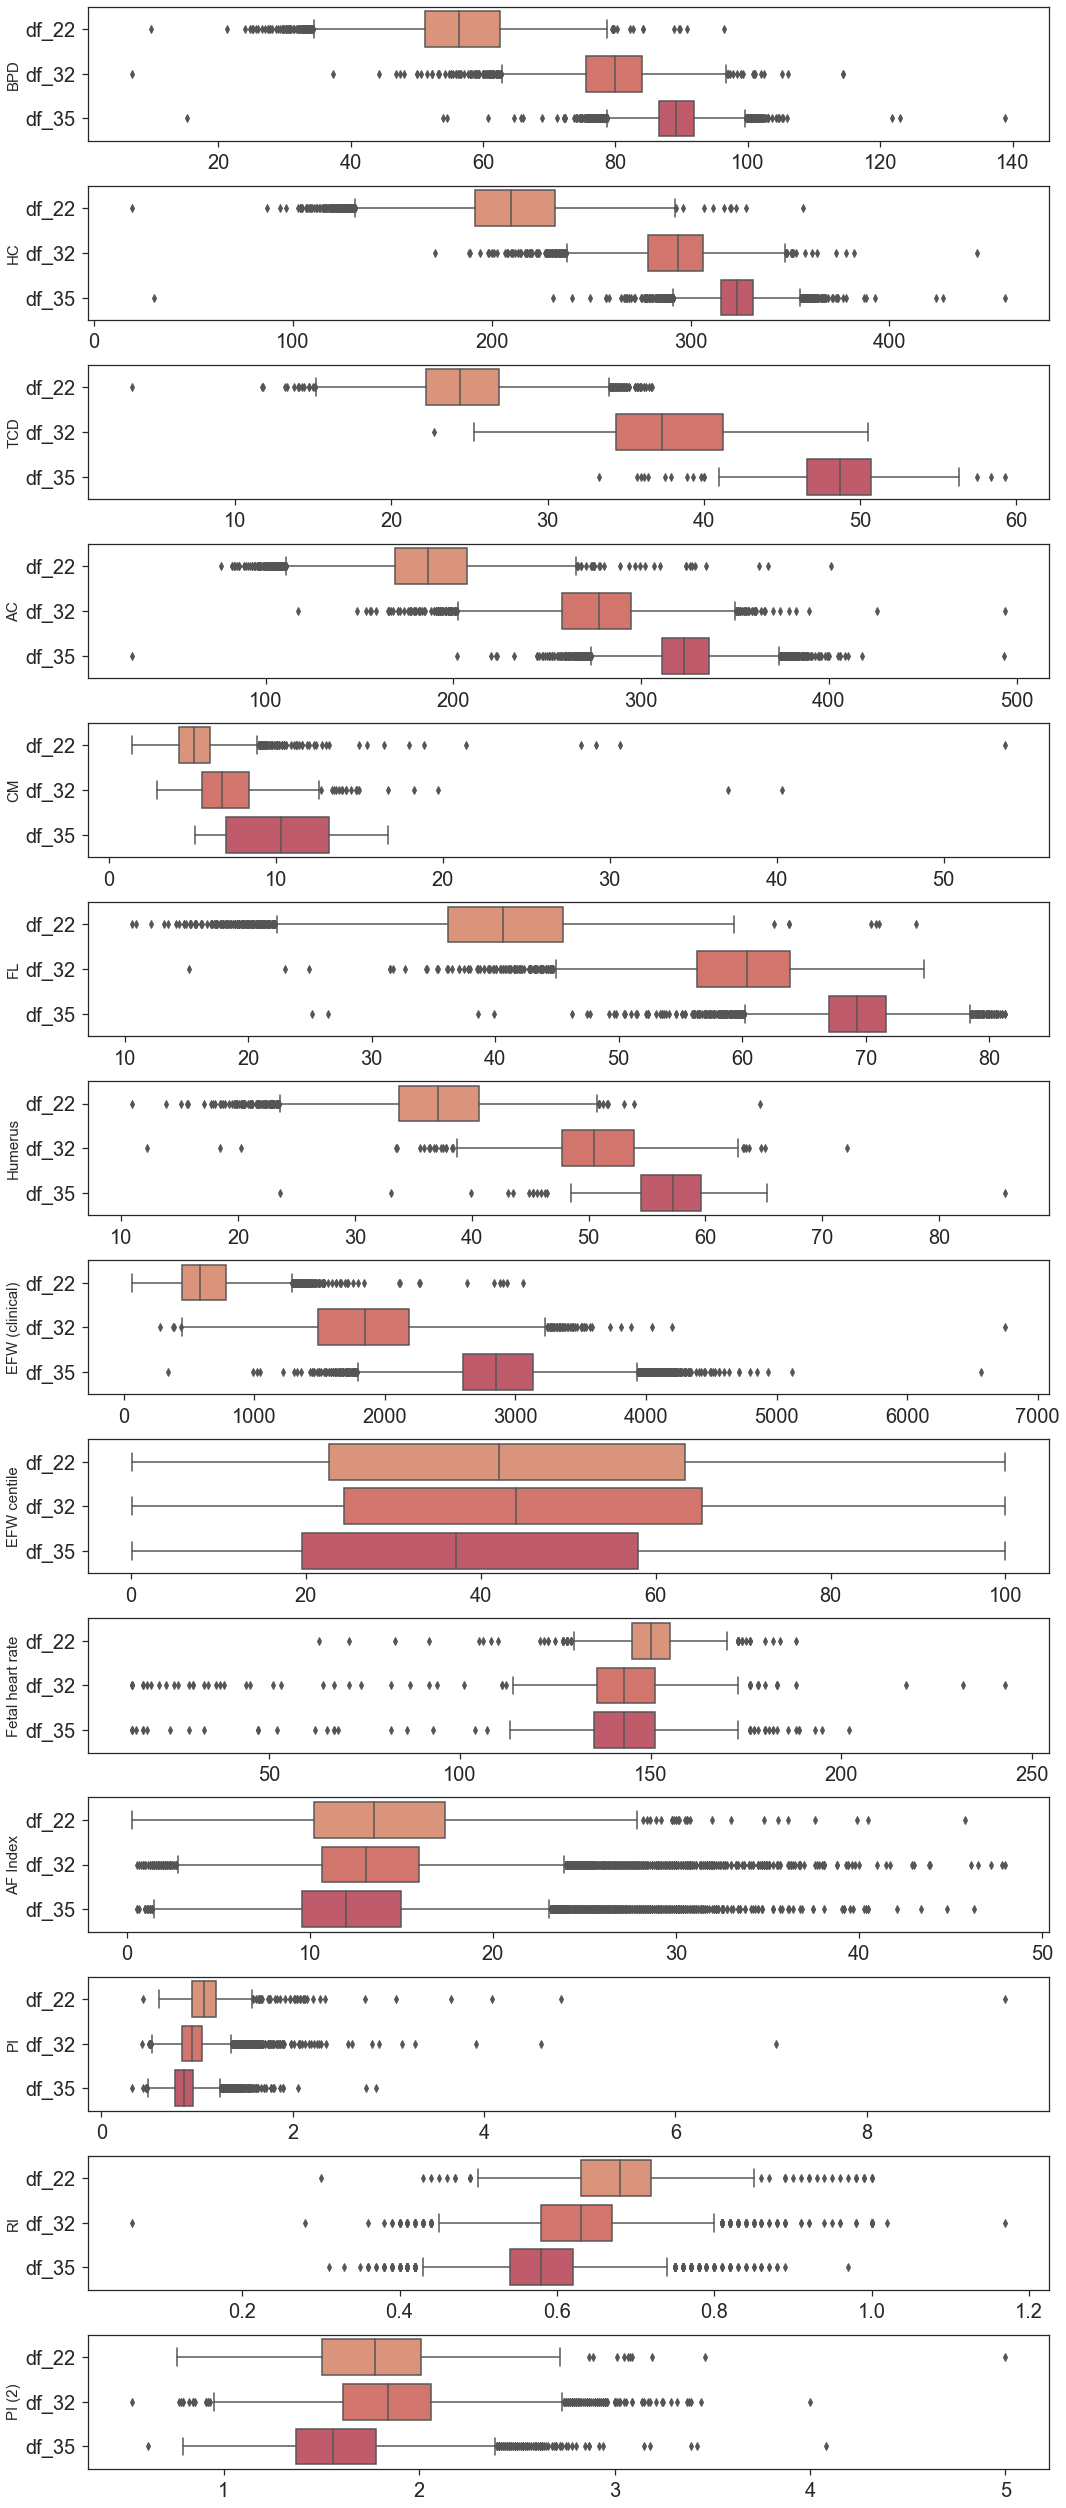

In [68]:
#wk22 --- wk32 --- wk35
visualize_val_edit(value_cols[:len(value_cols)//2], df_22, df_32, df_35)

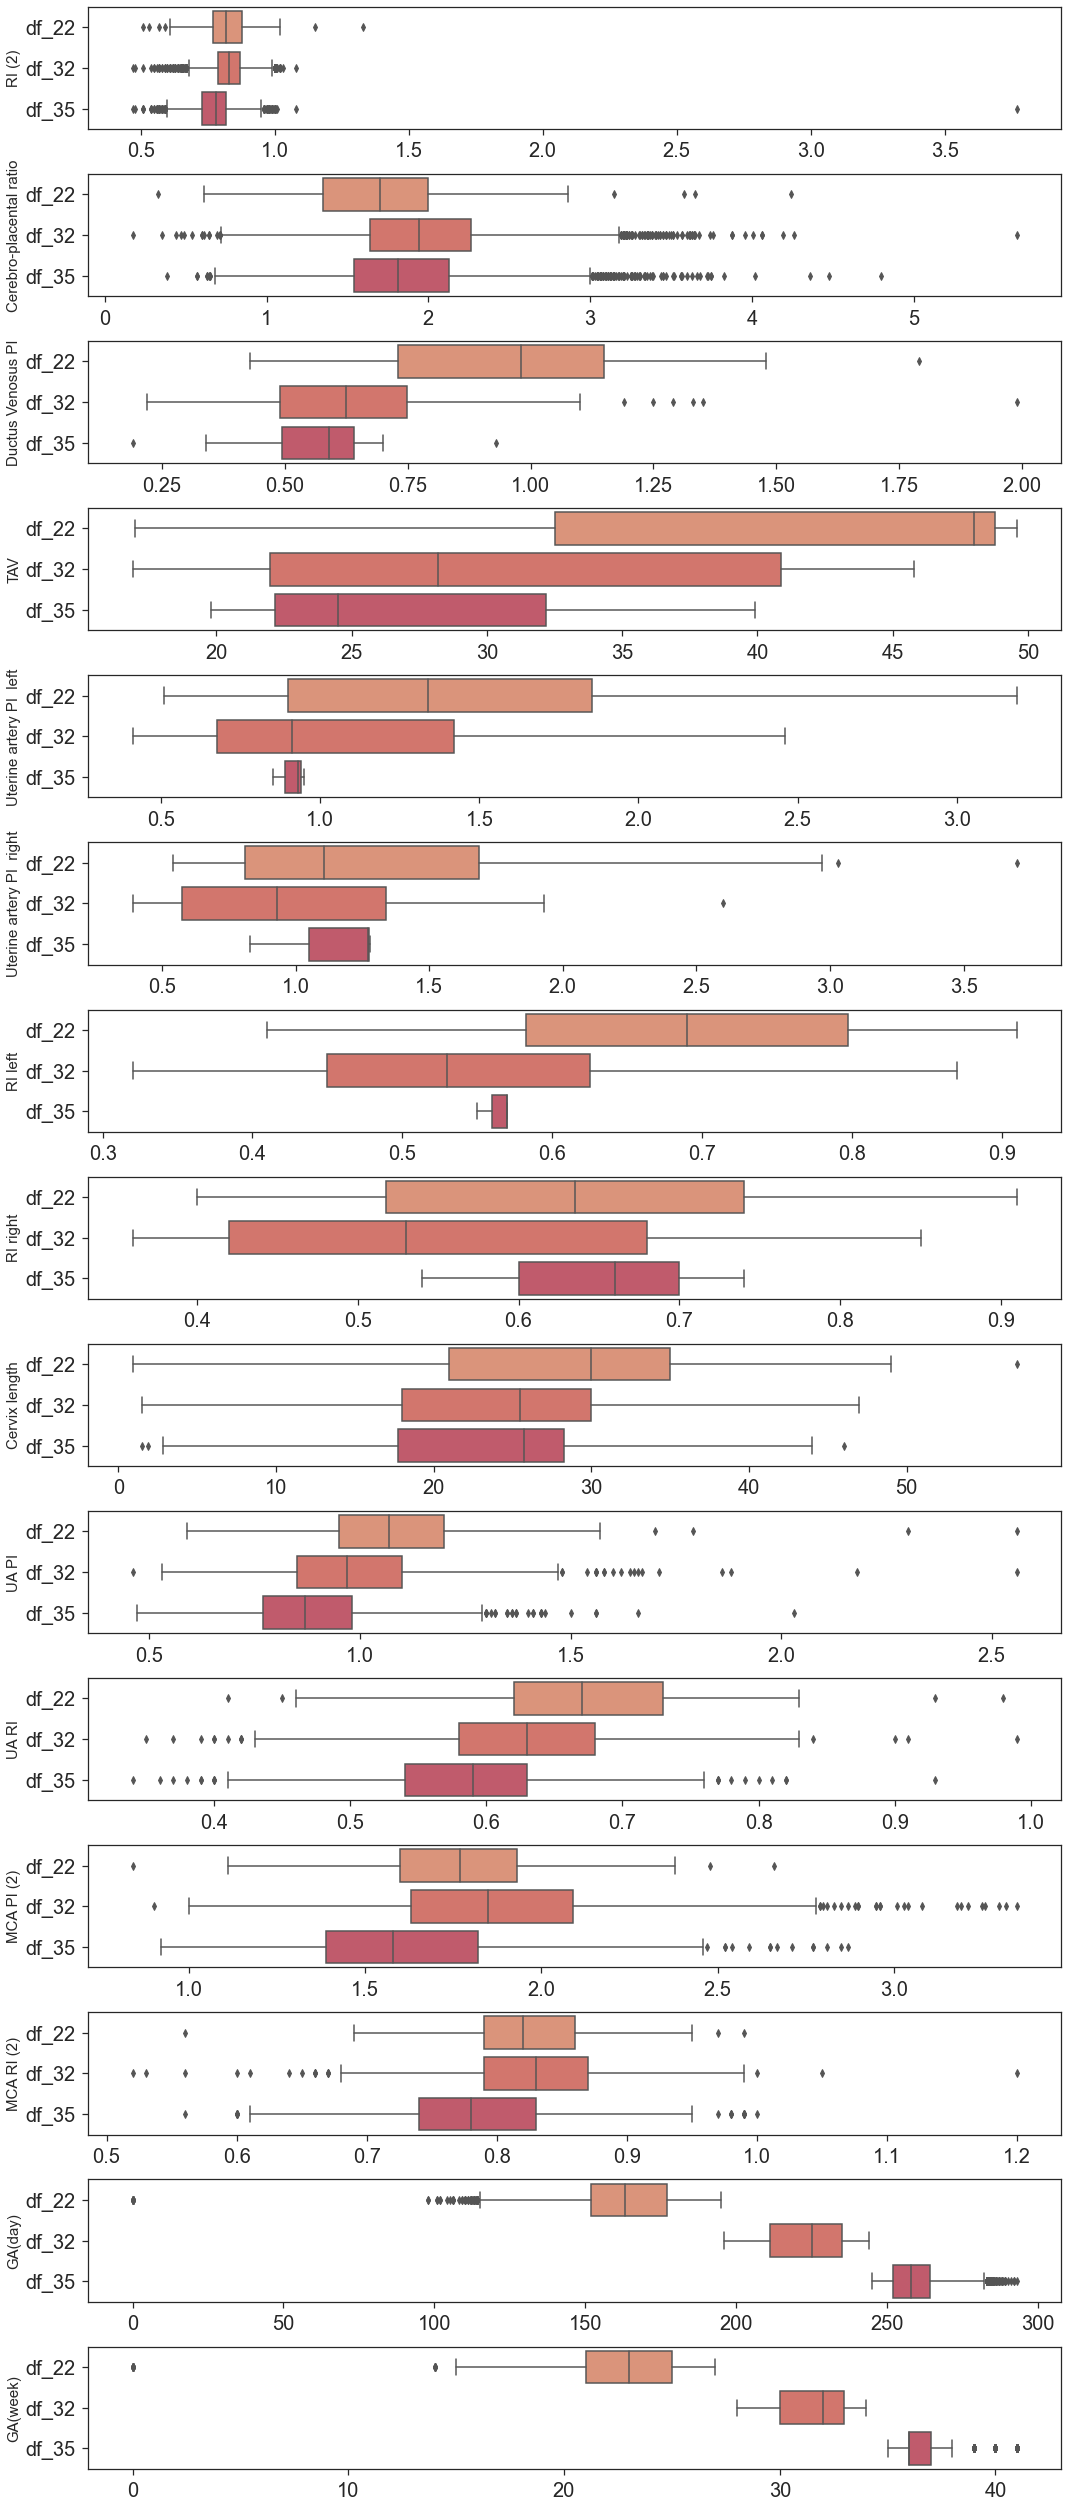

In [69]:
visualize_val_edit(value_cols[len(value_cols)//2:], df_22, df_32, df_35)

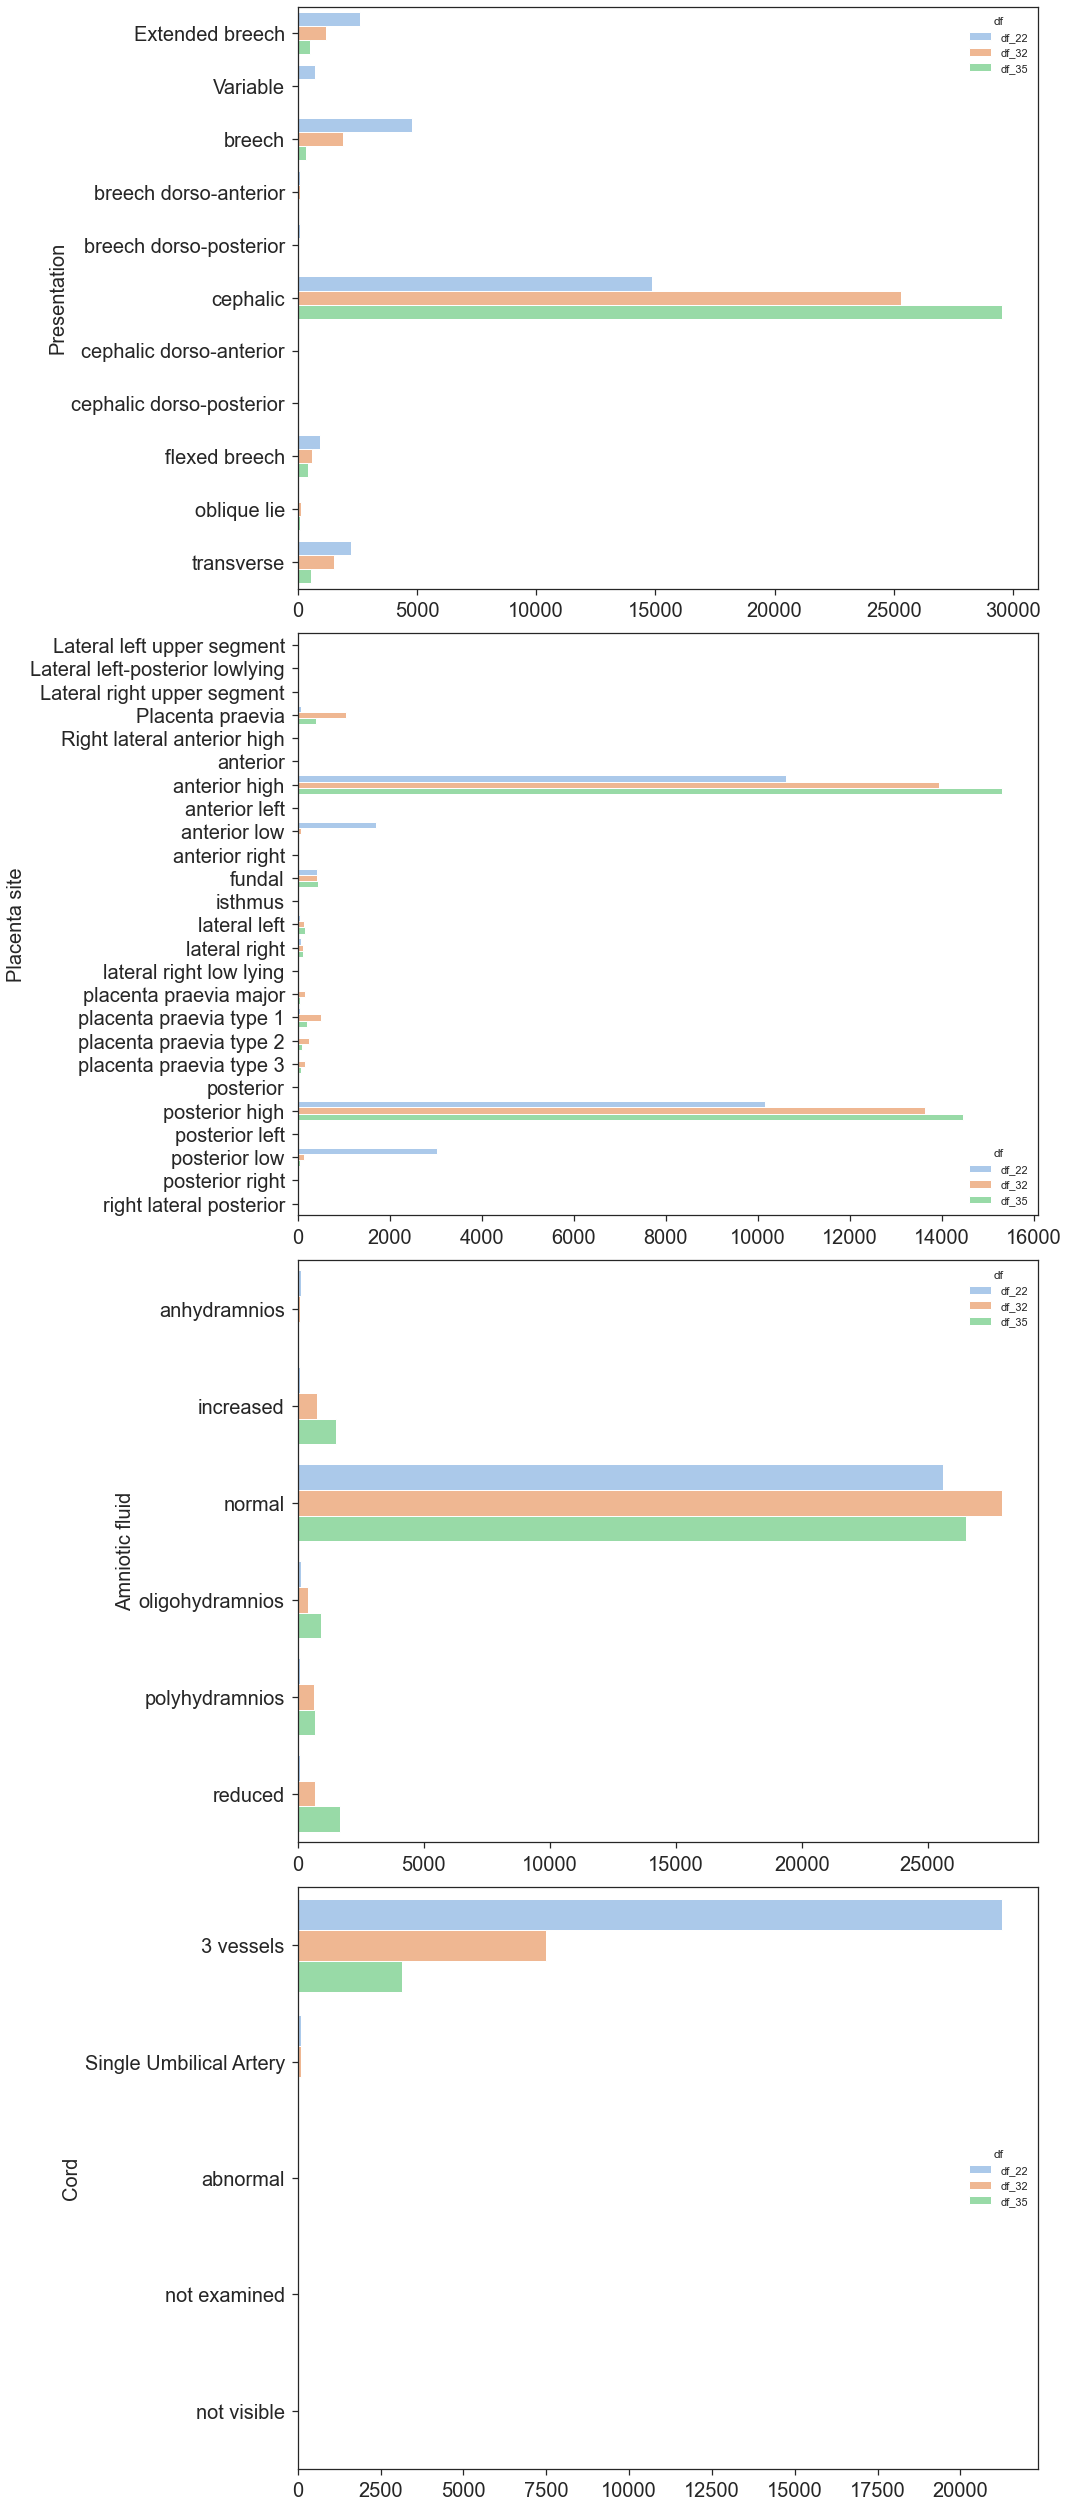

In [70]:
visualize_cat(cat_cols, df_22, df_32, df_35)

In [22]:
#cleaning outliers
def clean_outliers_zscore(df, z_score_list=[]):
    
    new_df = df.copy()
    
    if z_score_list==[]:
        z_score_list = new_df.select_dtypes('float64')

    cols_to_remove = []
    for col in new_df.columns: #get z_score
        if col in z_score_list:
            cols_to_remove.append(col)
            col_zscore = col + "_zscore"
            new_df[col_zscore] = (new_df[col] - new_df[col].mean())/new_df[col].std(ddof=0) 
            #if 1, then it will divide by n-1, unbiased in samplling (but in our case not sampling so we use ddof=0)

    rows_to_remove = []
    for col in new_df.columns:
        if 'zscore' in col:
            rows_to_remove +=  [i for i in new_df[ abs(new_df[col]) > 3].index] #filter outliers

    rows_to_remove = list(set(rows_to_remove))
    new_df = new_df.drop(rows_to_remove) #drop outliers
    new_df = new_df.loc[:, ~new_df.columns.str.contains('zscore')]
    
    return new_df, cols_to_remove

In [23]:
df_22_cleaned, _ = clean_outliers_zscore(df_22)
df_32_cleaned, _ = clean_outliers_zscore(df_32)
df_35_cleaned, _ = clean_outliers_zscore(df_35)

a,b,c = set(df_22_cleaned.select_dtypes('float64').columns), \
        set(df_32_cleaned.select_dtypes('float64').columns), \
        set(df_35_cleaned.select_dtypes('float64').columns)

common_features = a.intersection(b).intersection(c)            

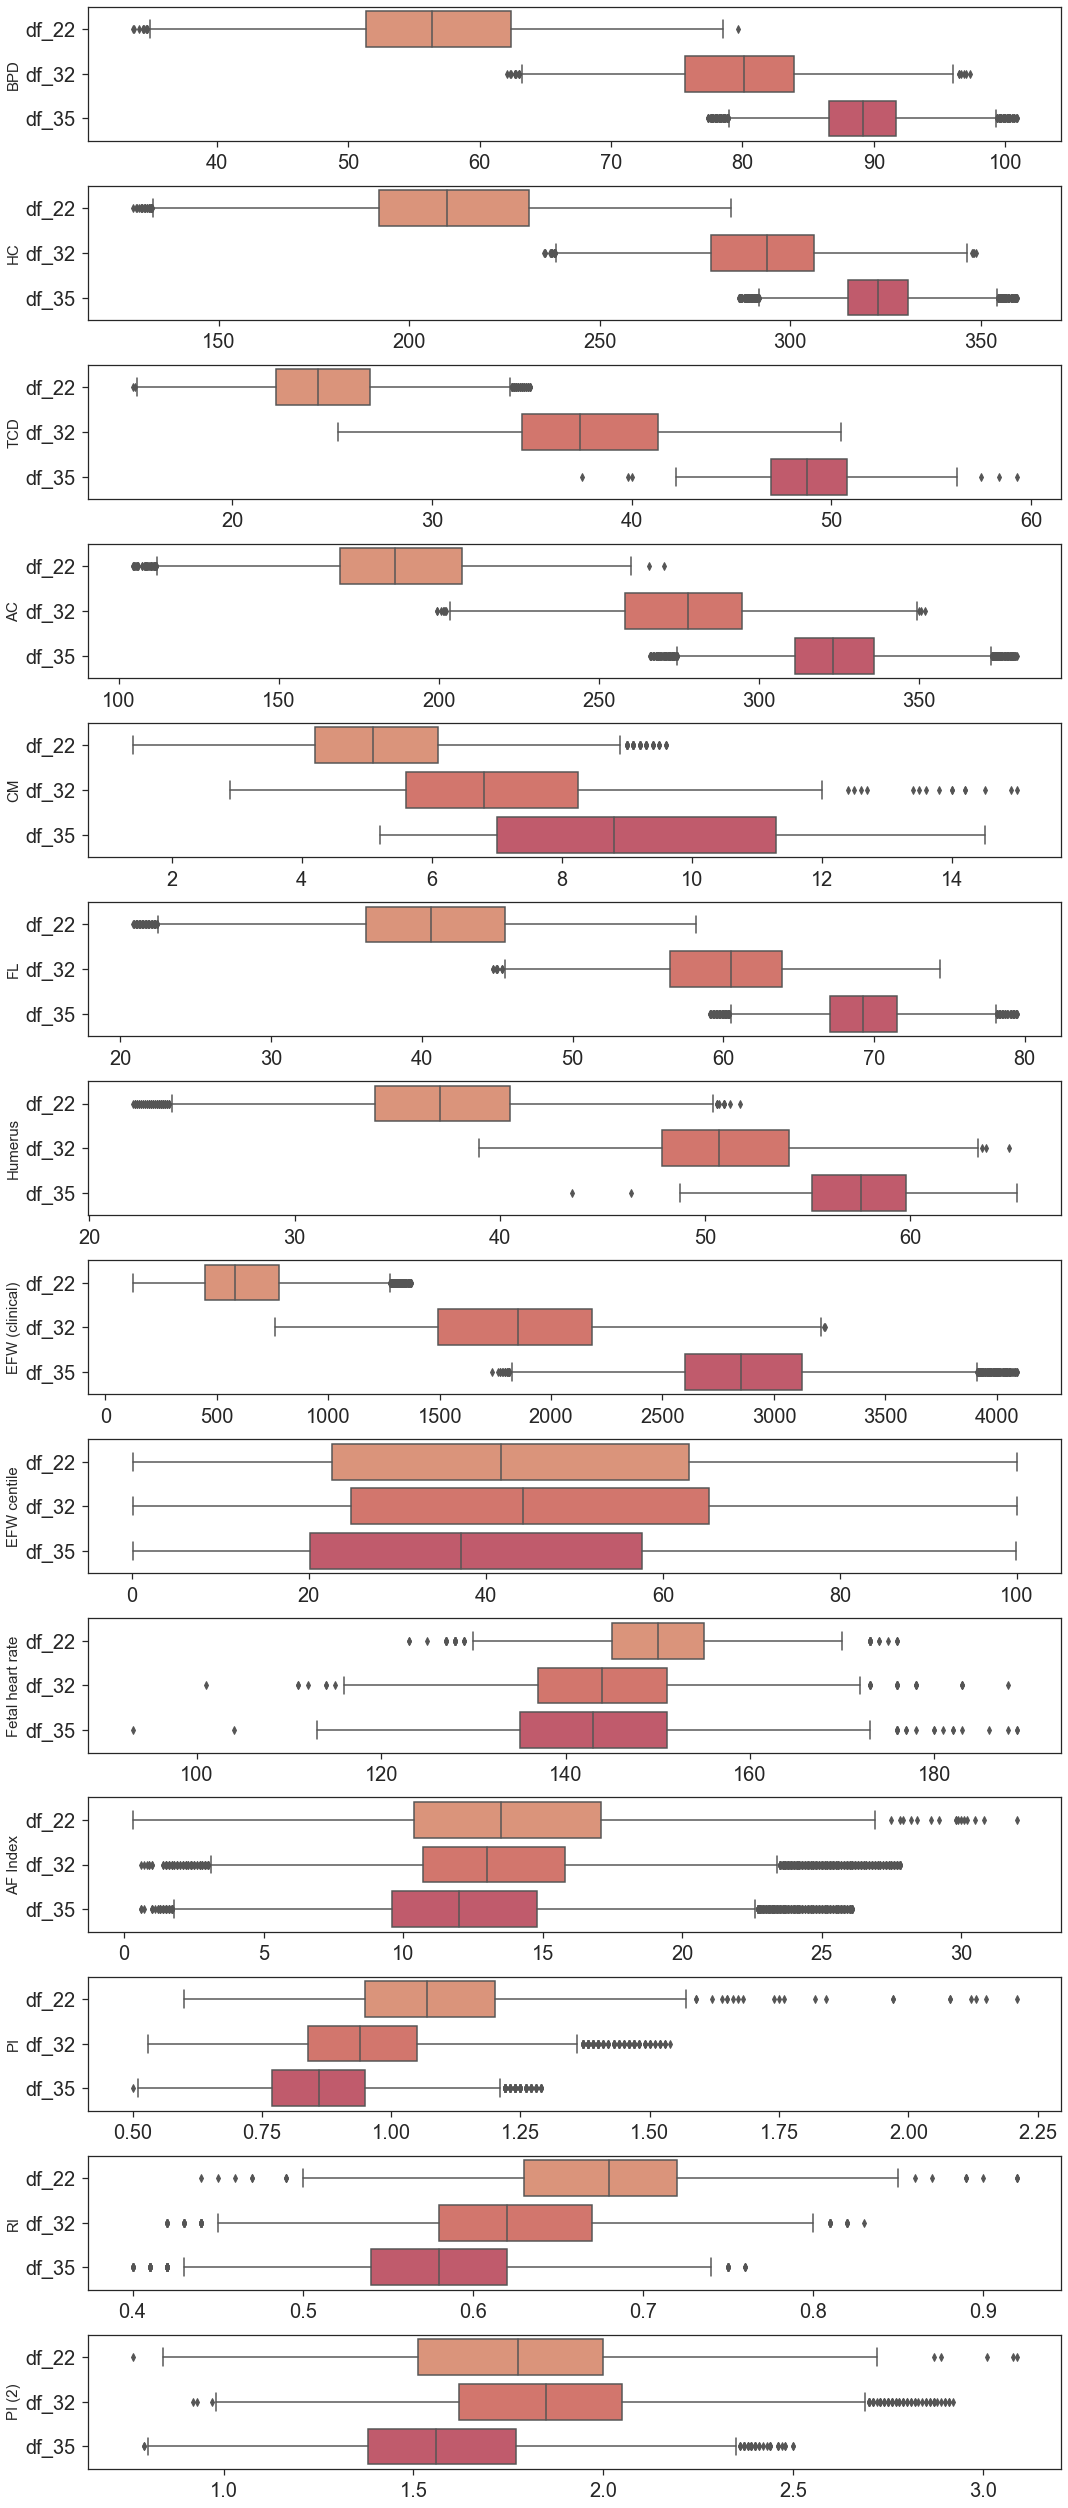

In [73]:
#wk22 --- wk32 --- wk35 (CLEANED)
visualize_val_edit(value_cols[:len(value_cols)//2], df_22_cleaned, df_32_cleaned, df_35_cleaned)

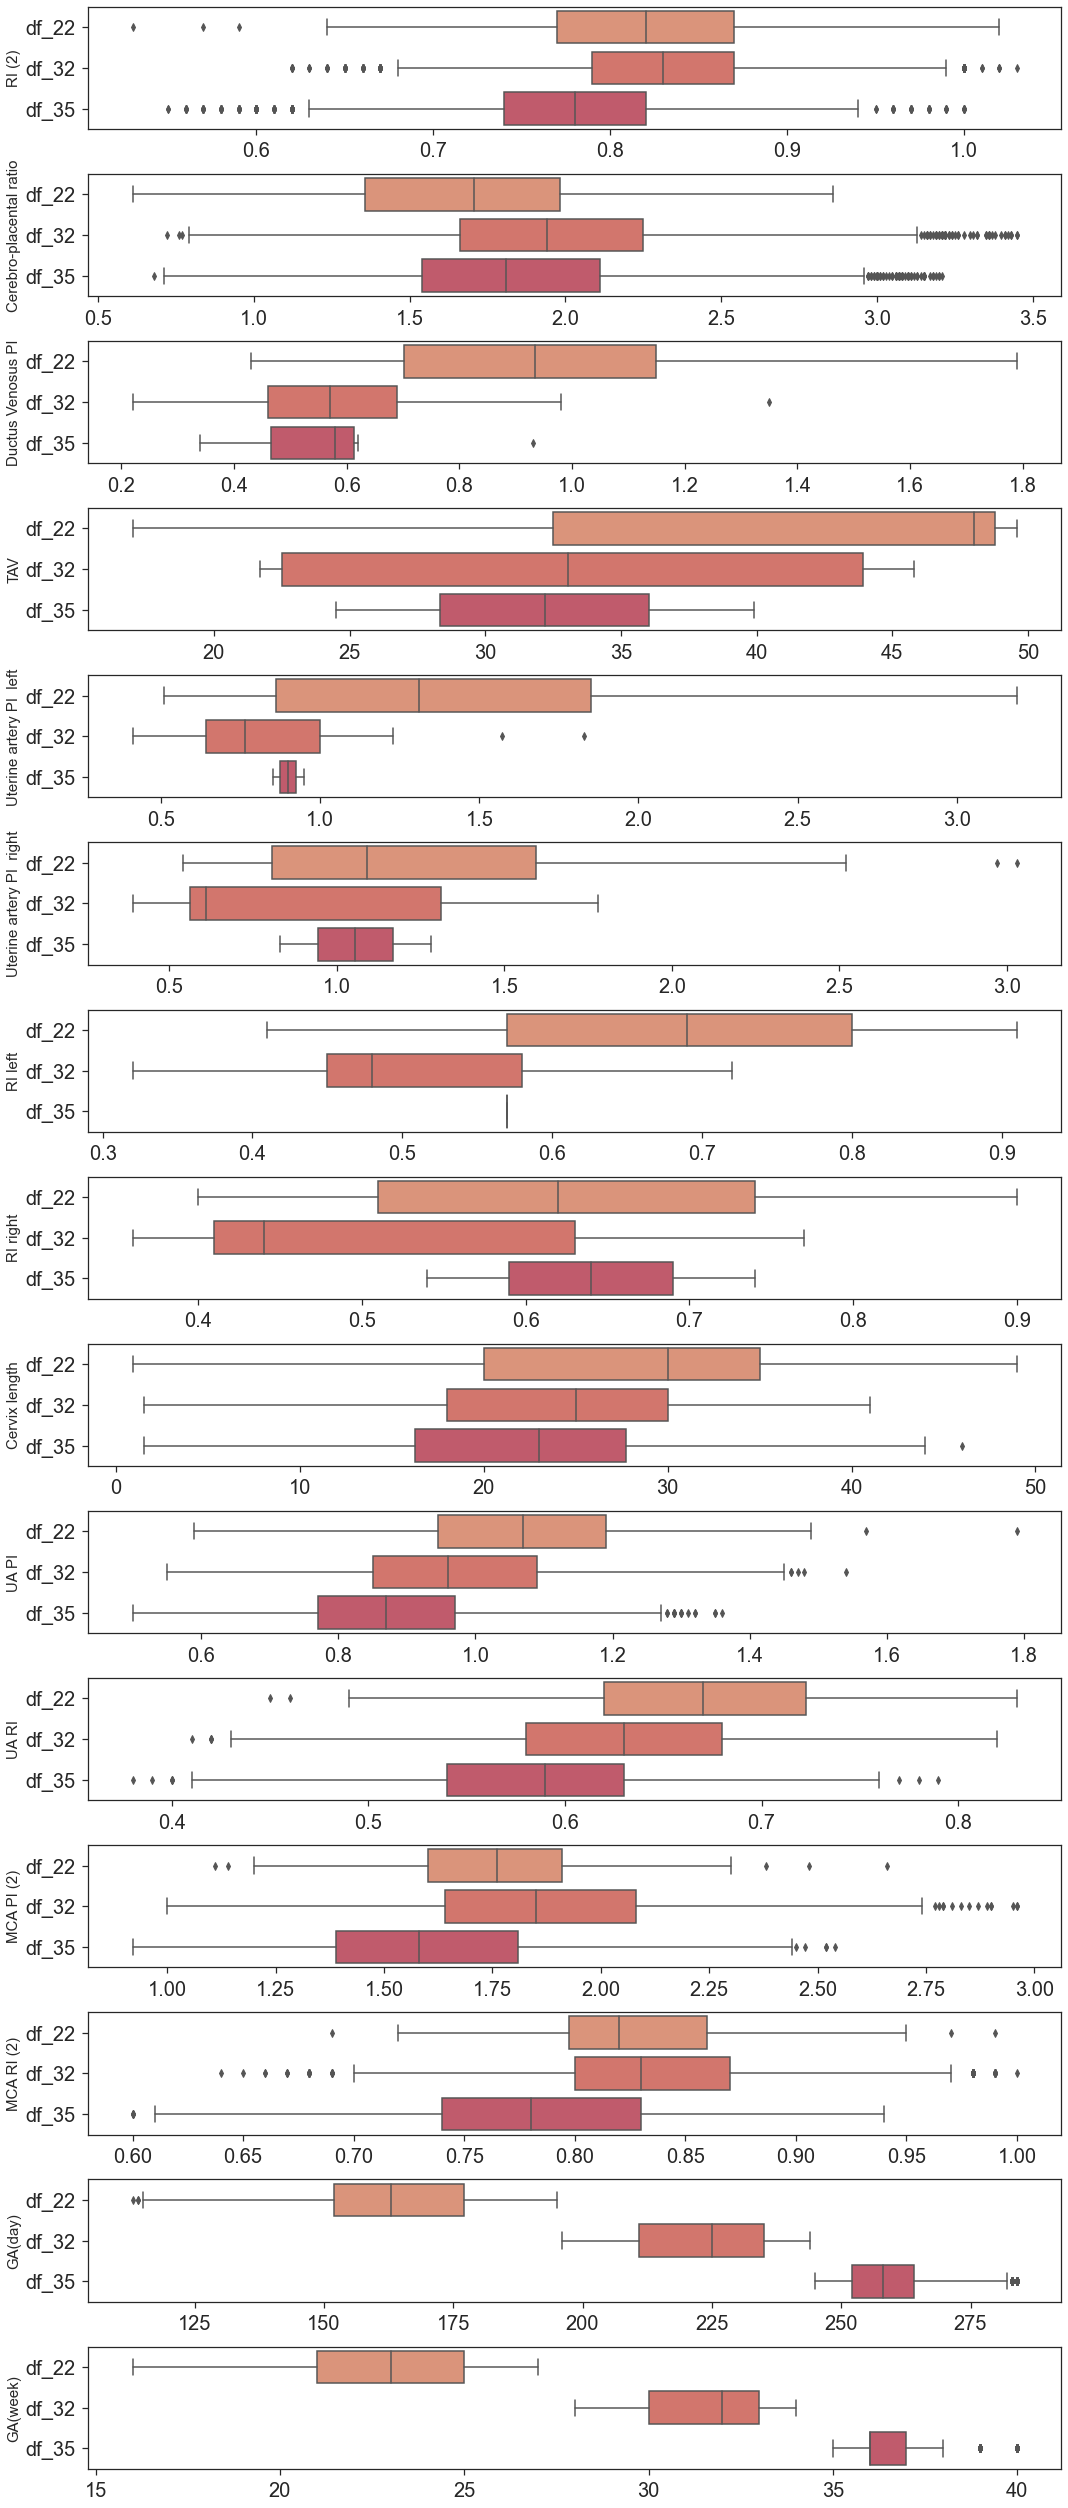

In [74]:
#wk22 --- wk32 --- wk35 (CLEANED)
visualize_val_edit(value_cols[len(value_cols)//2:], df_22_cleaned, df_32_cleaned, df_35_cleaned)

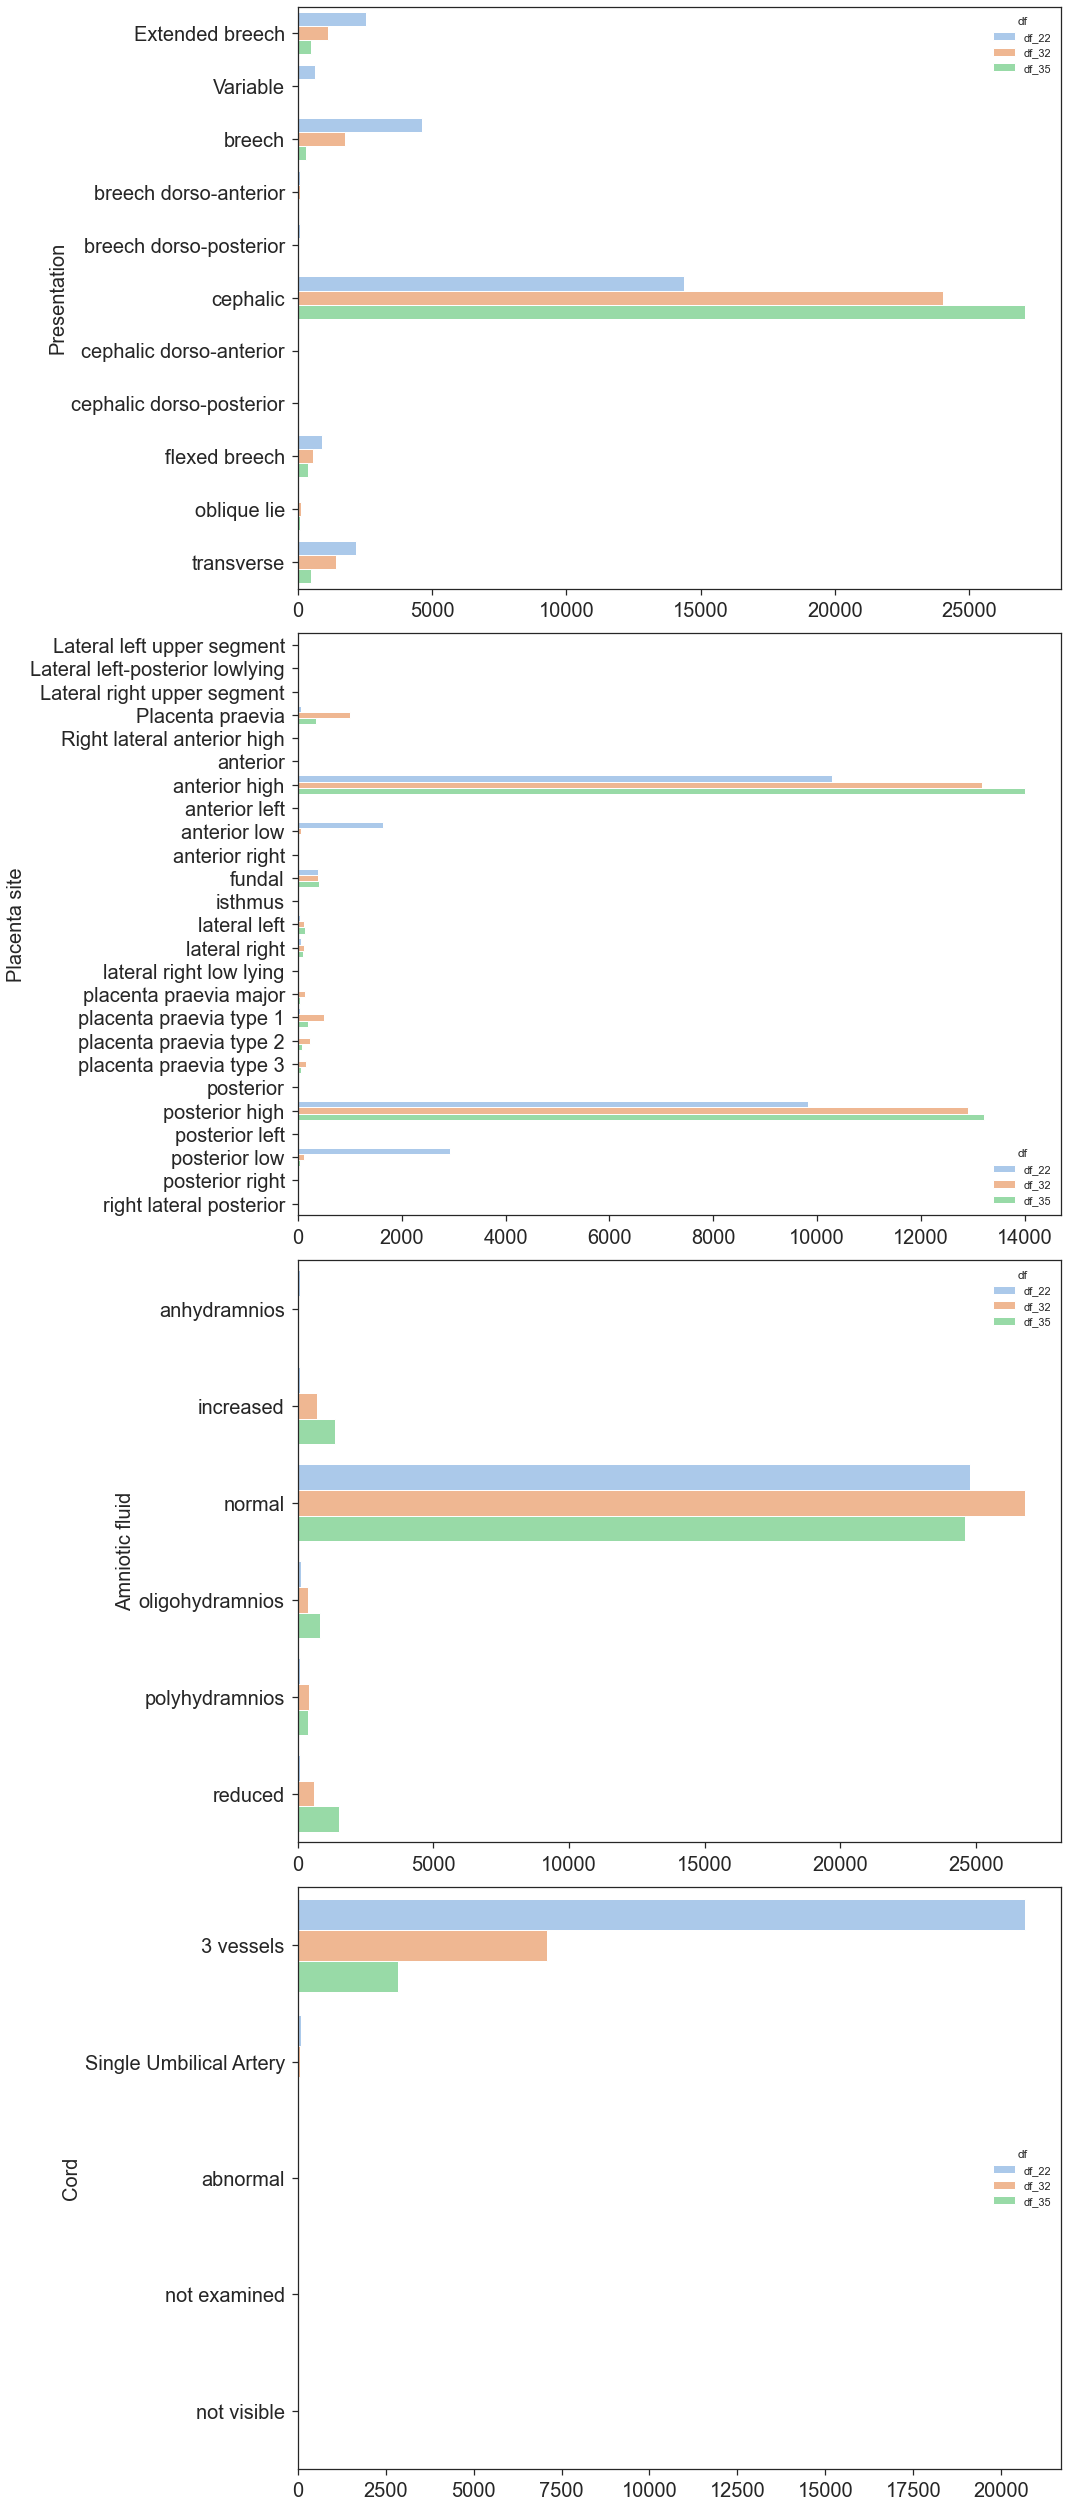

In [75]:
visualize_cat(cat_cols, df_22_cleaned, df_32_cleaned, df_35_cleaned)

### Summary:

From wk22 > wk32 > wk35: Float columns

1. Increasing:
	- BPD (55|80|90) 
        - the diameter of your baby's head/ The biparietal diameter (BPD) is measured as an outer-to-inner cranial measurement
	- HC  (210|290|320) 
        -  The occipitofrontal diameter (OFD) as the distance between the middle of the bone echoes. The head circumference is calculated by the formula: HC = 1.62 × (BPD + OFD).
	- TCD (24|37|48)
        - Fetal transverse cerebellar diameter
        - It is measured as the maximal diameter between the cerebellar hemispheres on an axial scan.
        - Is it hem in previous study? NO
	- AC  (180|275|320)
         - abdominal circumference -> circumference of the fetal abdomen (body space between the chest and pelvis)
	- CM  (5|7|10)
        - cisterna magna is the space between the inferior margin of the vermis and the posterior rim of the foramen magnum
        - Inferior margin –> inferior border. The caudal or lowermost margin of a structure.
        - Vermis is the unpaired, median portion of the cerebellum that connects the two hemispheres （小脑）
        - Posterior -> further back in position; of or nearer the rear or hind end.
        - Foramen magnum is the largest foramen of the skull
        - In short it is the space between those 2 things at the skull.
	- FL  (40|60|70) 
        - Femur length (FL) -> Measures the longest bone in the body and reflects the longitudinal growth of the fetus.
	- Humerus (38|50|58)
        - Humerus is the arm bone between your shoulder and your elbow.
	- EFW (600|1850|2900)
        - Estimated Fetal Weight
	- Cerebro-placental ratio (1.75|2|1.9)
        - Cerebroplacental ratio (CPR) is an obstetric ultrasound tool used as a predictor of adverse pregnancy outcome in both small for gestational age (SGA) and appropriate for gestational age (AGA) fetuses.
        - 
	- GA(day) (160|225|258)
	- GA(week) (23|32|36.5)
    
    
2. Remain:
	- EFW centile (40|40|40)
	- Uterine artery PI left (1.35|0.9|0.93)
        - Uterus's artery
        - Pulsatility index (PI) (also known as the Gosling index) is a calculated flow parameter in ultrasound, derived from the maximum, minimum, and mean Doppler frequency shifts during a defined cardiac cycle.
        - A high uterine artery pulsatility index reflects a defective development of placental bed spiral arteries in pregnancies complicated by hypertension and fetal growth retardation.
        
        - The mean PI in the right and left uterine artery are 1.09 and 0.81, with a range of 0.53 - 1.58 and 0.58 - 1.83 respectively. The RI has a mean of 0.59 and 0.65, while the range was 0.37-1.16 and 0.41 - 0.82 in both the right and left uterine artery respectively.
        
	- Ductus Veneous PI (1|0.625|0.6)
        - A shunt that allows oxygenated blood in the umbilical vein to bypass the liver and is essential for normal fetal circulation.
        - In medicine, a shunt is a hole or a small passage which moves, or allows movement of, fluid from one part of the body to another.
	- RI(2) (0.82|0.83|0.75)
        - Resistance Index is a measure of pulsatile blood flow that reflects the resistance to blood flow caused by microvascular bed distal to the site of measurement.
    
    
3. Decreasing:
	- Fetal heart rate (150|145|140)
	- AF index (13|12|12)
        - The sum of the deepest vertical pocket of fluid.
        - A normal amniotic fluid index is 5 cm to 25 cm using the standard assessment method. Less than 5 cm is considered oligohydramnios, and greater than 25 cm is considered polyhydramnios.
	- PI (1|1|0.9)
        - Pulsatility index
	- RI (0.68|0.62|0.58)
        - Resistance index
	- PI(2) (1.9|1.8|1.6)
	- TAV (47|28|24)
        - time-averaged velocity
        - https://radiopaedia.org/articles/umbilical-arterial-doppler-assessment
        - umbilical arterial S/D ratio (SDR): systolic velocity / diastolic velocity
        - pulsatility index (PI) (Gosling index): (PSV - EDV) / TAV
        - resistive index (RI) (Pourcelot index): (PSV - EDV) / PSV
        - PSV: peak systolic velocity
        - EDV: end-diastolic velocity
        - TAV: time-averaged velocity

	- Cervix Length (30|26|28)
        - A cylinder-shaped neck of tissue that connects the vagina and uterus.
	- UA PI (1.1|0.95|0.9)
        - Uterine Artery Pusatility index(mentioned before)
	- UA RI (0.68|0.62|0.59)
        - Uterine Artery Resistance index
	- MCA PI(2) (1.8|1.9|1.6)
        - Fetal middle cerebral arterial (MCA) Doppler assessment is an important part of assessing fetal cardiovascular distress, fetal anemia or fetal hypoxia.
	- MCA RI(2) (0.82|0.82|0.78)
    
    
4. Unclear:
	- Uterine artery PI right (1.1|0.95|1.28)
	- RI right (0.62|0.53|0.66)
	- RI left (0.7|0.52|0.565)
    
From wk22 > wk32 > wk35: Category columns

1. Presentation: The way that the fetus presented.
     - Extended breech, variable, breech, flexed breech and transverse mostly become cephalic
- Placenta site:
     - posterior low, anterior low become less, placenta praevia increase then decrease.
- Amniotic fluid:
     - Gradually become more variations
- Cord:
     - Remain 3 Vessels 
         - baby's “supply line” because it carries the baby's blood back and forth, between the baby and the placenta.

## Comparing to previous data

|Prev | Now |
|-|-|
| EFW_22 | EFW (Clinical) |
| GA(Day)_22 | GA(day) |
| Baby Gender_22 | None |
| CM_22 | CM |
| Ut PI_22 | UA PI / left / right |
| Va_22 | None |
| Nuchal fold_22 | None |
| Hem_22 | None |
| BPD_22 | BPD |
| GA(Week)_32 | Yes |
| EFW_32 | Yes |

In [375]:
df_master.columns

Index(['PID', 'Case number', 'Exam', 'Fetus', 'Hospital no.', 'Ethnic_group',
       'BPD', 'HC', 'TCD', 'AC', 'CM', 'FL', 'Humerus', 'EFW (clinical)',
       'EFW centile', 'Fetal heart rate', 'Presentation', 'Placenta site',
       'AF Index', 'Amniotic fluid', 'Cord', 'PI', 'RI', 'EDF', 'PI (2)',
       'RI (2)', 'Cerebro-placental ratio', 'A-wave', 'Ductus Venosus PI',
       'TAV', 'Uterine artery PI  left', 'Uterine artery PI  right', 'RI left',
       'RI right', 'Notch', 'Funnelling', 'Cervix length',
       'Estimated fetal weight', 'Examination date', 'UA PI', 'UA RI',
       'MCA PI (2)', 'MCA RI (2)', 'GA(day)', 'GA(week)', 'df_cat'],
      dtype='object')

In [34]:
def get_df_details(df):
    print('Total Scans:', df.shape[0])
    print('Unique Patients:', len(df['Hospital no.'].unique()))

In [377]:
# df_22 = df_22_cleaned
# df_32 = df_32_cleaned
# df_35 = df_35_cleaned

get_df_details(df_22)
get_df_details(df_32)
get_df_details(df_35)

Total Scans: 26603
Unique Patients: 18811
Total Scans: 31136
Unique Patients: 21687
Total Scans: 31658
Unique Patients: 24135


<AxesSubplot:>

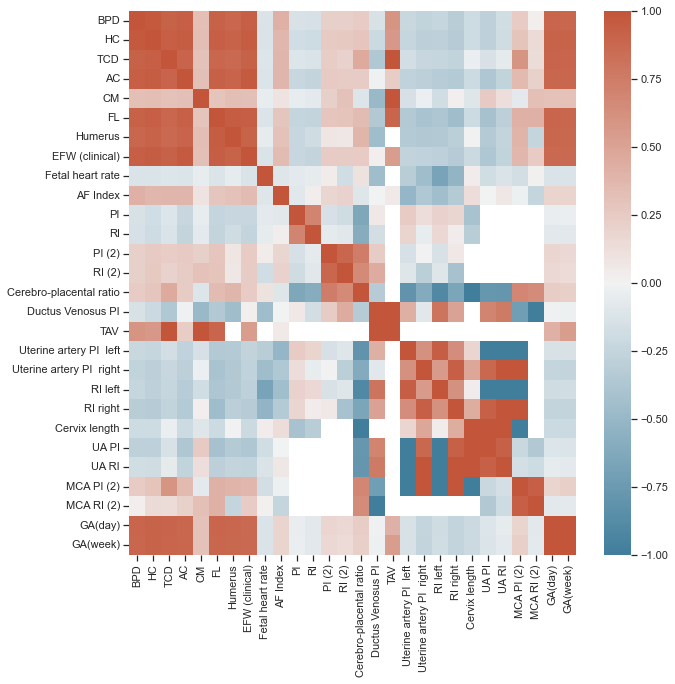

In [24]:
columns_to_drop = ['PID', 'Case number', 'Exam', 'Fetus','Hospital no.', 'EFW centile', ]

# correlation graph
f, ax = plt.subplots(figsize=(10,10))
corr = df_22.drop(columns_to_drop, axis=1).corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap)

#From the correlation graph:
#1. Removed Highly Correlated features with non-target
#2. Understand that none of the features has high correlation with target.

# Mergingg
1. Rename all
- Take Hospital no., GA(week) and EFW(clinical) of respective week 
    - Wk22 + GA(Week)32 -> EFW wk32
    - Wk22 + GA(Week)35 -> EFW wk35
    - WK32 + GA(Week)35 -> EFW wk35
    - WK22 + WK32 + GA(Week)35 -> EFW wk35
    
- Remove not null < 400
- Get non-null columns of the most common features (~20000 non-null)
- Remove not null again < 400
- Clean Category

In [378]:
len(df_32['Hospital no.'].unique())

21687

In [25]:
df_32_output = df_32[['Hospital no.', 'GA(week)', 'EFW (clinical)']]
df_35_output = df_35[['Hospital no.', 'GA(week)', 'EFW (clinical)']]

df_32_output = df_32_output.rename(columns={'GA(week)': 'GA(week)_32', 'EFW (clinical)': 'EFW_32'})
df_35_output = df_35_output.rename(columns={'GA(week)': 'GA(week)_35', 'EFW (clinical)': 'EFW_35'})

In [26]:
df_22_32 = pd.merge(df_22, df_32_output, on='Hospital no.', how='inner')
df_22_32 = df_22_32.rename(columns={'Estimated fetal weight': 'EFW Formulae', 'EFW (clinical)': 'EFW_22'})

df_32_35 = pd.merge(df_32, df_35_output, on='Hospital no.', how='inner')
df_32_35 = df_32_35.rename(columns={'Estimated fetal weight': 'EFW Formulae', 'EFW (clinical)': 'EFW_32'})

In [432]:
df_22_32.columns

Index(['PID', 'Case number', 'Exam', 'Fetus', 'Hospital no.', 'Ethnic_group',
       'BPD', 'HC', 'TCD', 'AC', 'CM', 'FL', 'Humerus', 'EFW_22',
       'EFW centile', 'Fetal heart rate', 'Presentation', 'Placenta site',
       'AF Index', 'Amniotic fluid', 'Cord', 'PI', 'RI', 'EDF', 'PI (2)',
       'RI (2)', 'Cerebro-placental ratio', 'A-wave', 'Ductus Venosus PI',
       'TAV', 'Uterine artery PI  left', 'Uterine artery PI  right', 'RI left',
       'RI right', 'Notch', 'Funnelling', 'Cervix length', 'EFW Formulae',
       'Examination date', 'UA PI', 'UA RI', 'MCA PI (2)', 'MCA RI (2)',
       'GA(day)', 'GA(week)', 'df_cat', 'GA(week)_32', 'EFW_32'],
      dtype='object')

In [433]:
get_df_details(df_32_35)

Total Scans: 30519
Unique Patients: 13470


## Cleaning of df_22_32

In [27]:
null_threshold = 400
to_drop = list(df_22_32.loc[:, df_22_32.isnull().sum() > (df_22_32.shape[0] - null_threshold)])
df_22_32_v2 = df_22_32.drop(to_drop, axis=1)
df_22_32_v2 = df_22_32_v2.drop(['PID', 'Case number', 'Exam', 'Fetus', 'EFW centile'], axis=1)

df_22_32_v2 = df_22_32_v2[   ~df_22_32_v2['BPD'].isnull() &
                             ~df_22_32_v2['HC'].isnull() & 
                             ~df_22_32_v2['TCD'].isnull() & 
                             ~df_22_32_v2['AC'].isnull() & 
                             ~df_22_32_v2['CM'].isnull() &
                             ~df_22_32_v2['Presentation'].isnull() &
                             ~df_22_32_v2['Placenta site'].isnull() &
                             ~df_22_32_v2['Amniotic fluid'].isnull() &
                             ~df_22_32_v2['Cord'].isnull() 
                            ]

df_22_32_v2 = df_22_32_v2[df_22_32_v2['Cord'].isin(['3 vessels', 'Single Umbilical Artery', 'abnormal'])]

In [28]:
to_drop_v2 = list(df_22_32_v2.loc[:, df_22_32_v2.isnull().sum() > (df_22_32_v2.shape[0] - null_threshold)])
df_22_32_v3 = df_22_32_v2.drop(to_drop_v2, axis=1)

#clean up unused categories
cat_cols = df_22_32_v3.select_dtypes(include=['category']).columns

for col in cat_cols:
    df_22_32_v3[col] = df_22_32_v3[col].cat.remove_unused_categories()

In [29]:
df_22_32_v3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19425 entries, 0 to 31261
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Hospital no.      19425 non-null  object        
 1   BPD               19425 non-null  float64       
 2   HC                19425 non-null  float64       
 3   TCD               19425 non-null  float64       
 4   AC                19425 non-null  float64       
 5   CM                19425 non-null  float64       
 6   FL                19425 non-null  float64       
 7   Humerus           10492 non-null  float64       
 8   EFW_22            19425 non-null  float64       
 9   Fetal heart rate  2649 non-null   float64       
 10  Presentation      19425 non-null  category      
 11  Placenta site     19425 non-null  category      
 12  Amniotic fluid    19425 non-null  category      
 13  Cord              19425 non-null  category      
 14  EFW Formulae      1942

In [30]:
df_22_32_v3.columns

Index(['Hospital no.', 'BPD', 'HC', 'TCD', 'AC', 'CM', 'FL', 'Humerus',
       'EFW_22', 'Fetal heart rate', 'Presentation', 'Placenta site',
       'Amniotic fluid', 'Cord', 'EFW Formulae', 'Examination date', 'GA(day)',
       'GA(week)', 'df_cat', 'GA(week)_32', 'EFW_32'],
      dtype='object')

In [31]:
df_22_32_v3.shape

(19425, 21)

In [32]:
#cleaning outliers
#['BPD', 'HC', 'TCD', 'AC', 'CM', 'FL', 'Humerus', 'EFW (clinical)', 'Fetal heart rate', 'AF Index', 'PI', 'RI', 'GA(day)']
z_score_list = ['BPD', 'HC', 'TCD', 'AC', 'CM', 'FL','Humerus', 'EFW (clinical)', 'Fetal heart rate', 'GA(day)',
                'GA(week)']

df_22_32_v4, cols_affected = clean_outliers_zscore(df_22_32_v3, z_score_list)

In [35]:
get_df_details(df_22_32_v4)

Total Scans: 19169
Unique Patients: 9105


In [36]:
print(cols_affected)

['BPD', 'HC', 'TCD', 'AC', 'CM', 'FL', 'Humerus', 'Fetal heart rate', 'GA(day)', 'GA(week)']


In [37]:
def visualize_val_single_df(df):
    value_cols = df.select_dtypes(include=['float64']).columns
    section = [math.ceil(i) for i in np.linspace(start = 0, stop = len(value_cols), num = 5)]
    for i in range(len(section)-1):
        cols = value_cols[section[i]: section[i+1]]
        fig, ax = plt.subplots(len(cols), 1, figsize=(20,20))
        for index, col in enumerate(cols):
            sns.set_palette('flare')
            a = sns.boxplot(x=col, data=df, ax=ax[index])
            a.set_xlabel('', fontsize = 20.0) # X label
            a.set_ylabel(col, fontsize=20.0)
            a.tick_params(labelsize=20)

    fig.tight_layout()
    plt.show()
    
def visualize_cat_single_df(df, hue=None):
    '''visulizing categorical data'''
    cat_cols = df.select_dtypes(include=['category']).columns
    fig, ax = plt.subplots(len(cat_cols) , 1, figsize=(20,20))

    for index, col in enumerate(cat_cols):
        sns.set_palette("pastel")
        b = sns.countplot(y=col, data=df, ax=ax[index], hue=hue)
        b.set_xlabel('', fontsize = 20.0) # X label
        b.set_ylabel(col, fontsize = 20.0) # Y label
        b.tick_params(labelsize=20)

    fig.tight_layout()
    plt.show()

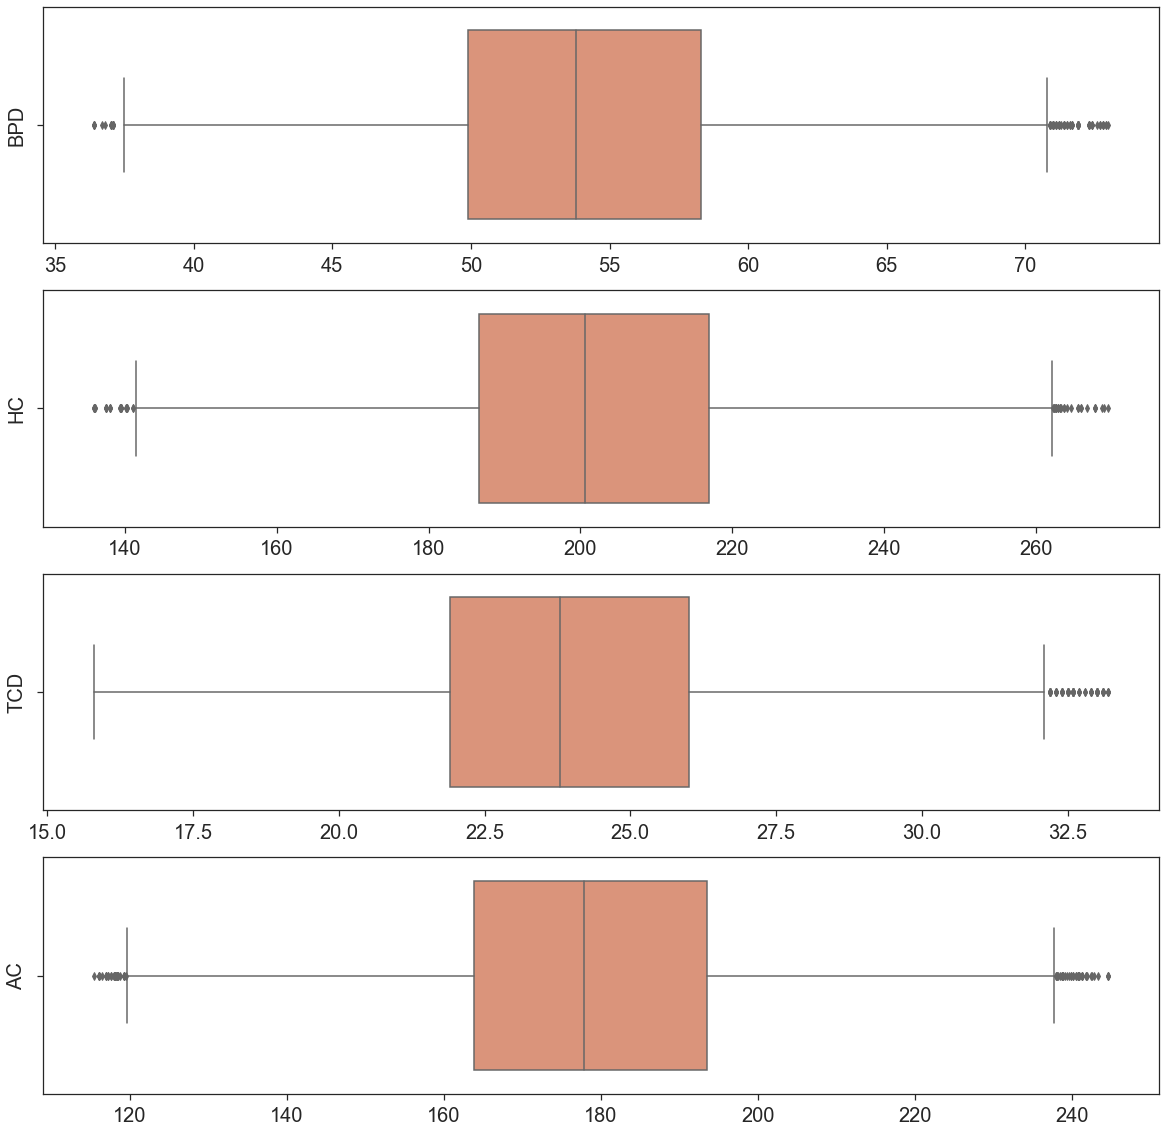

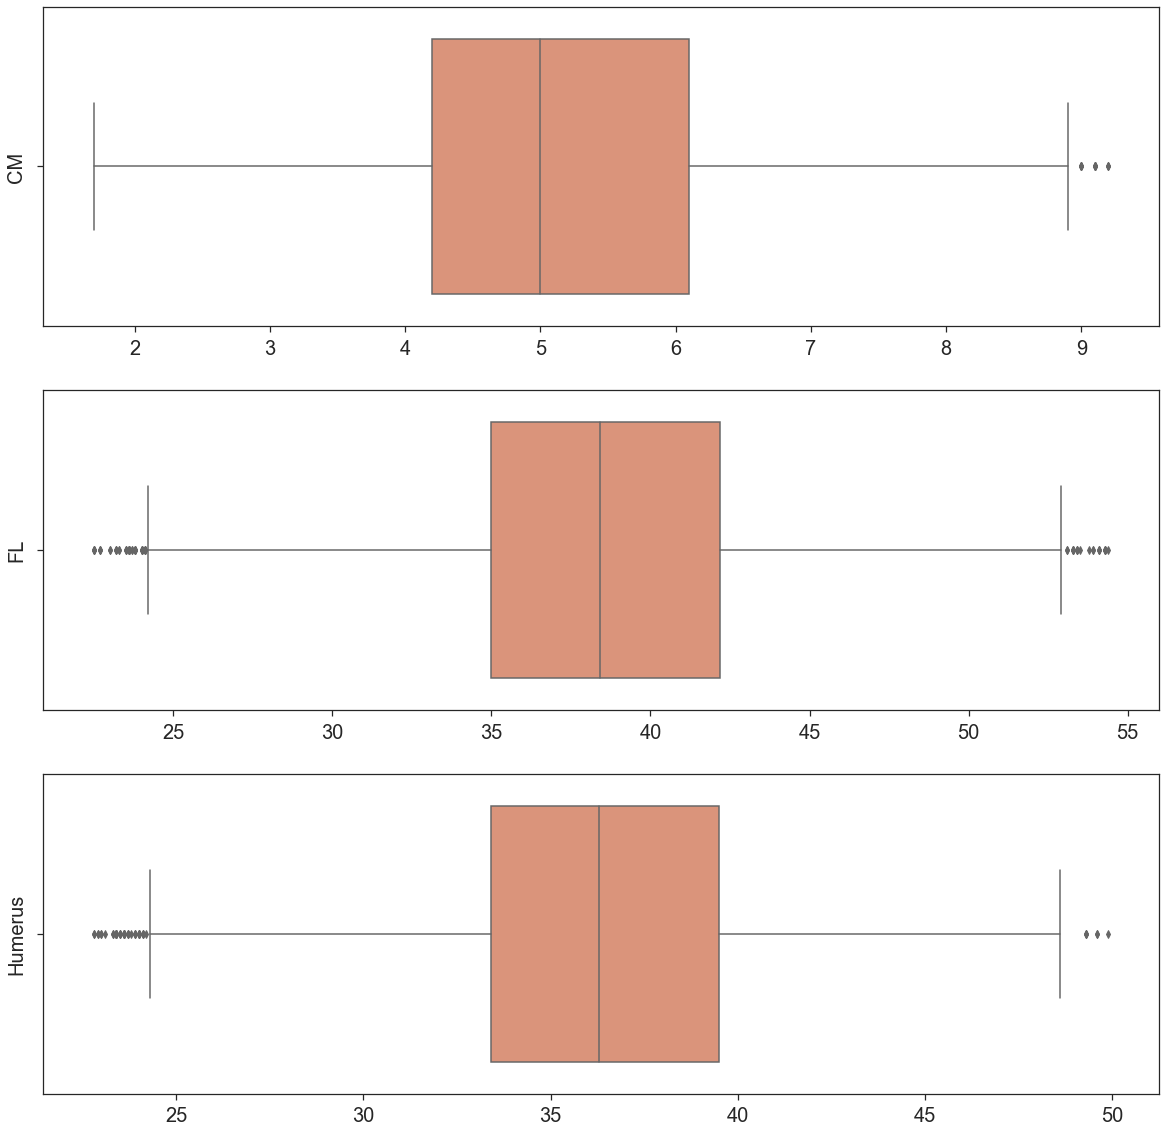

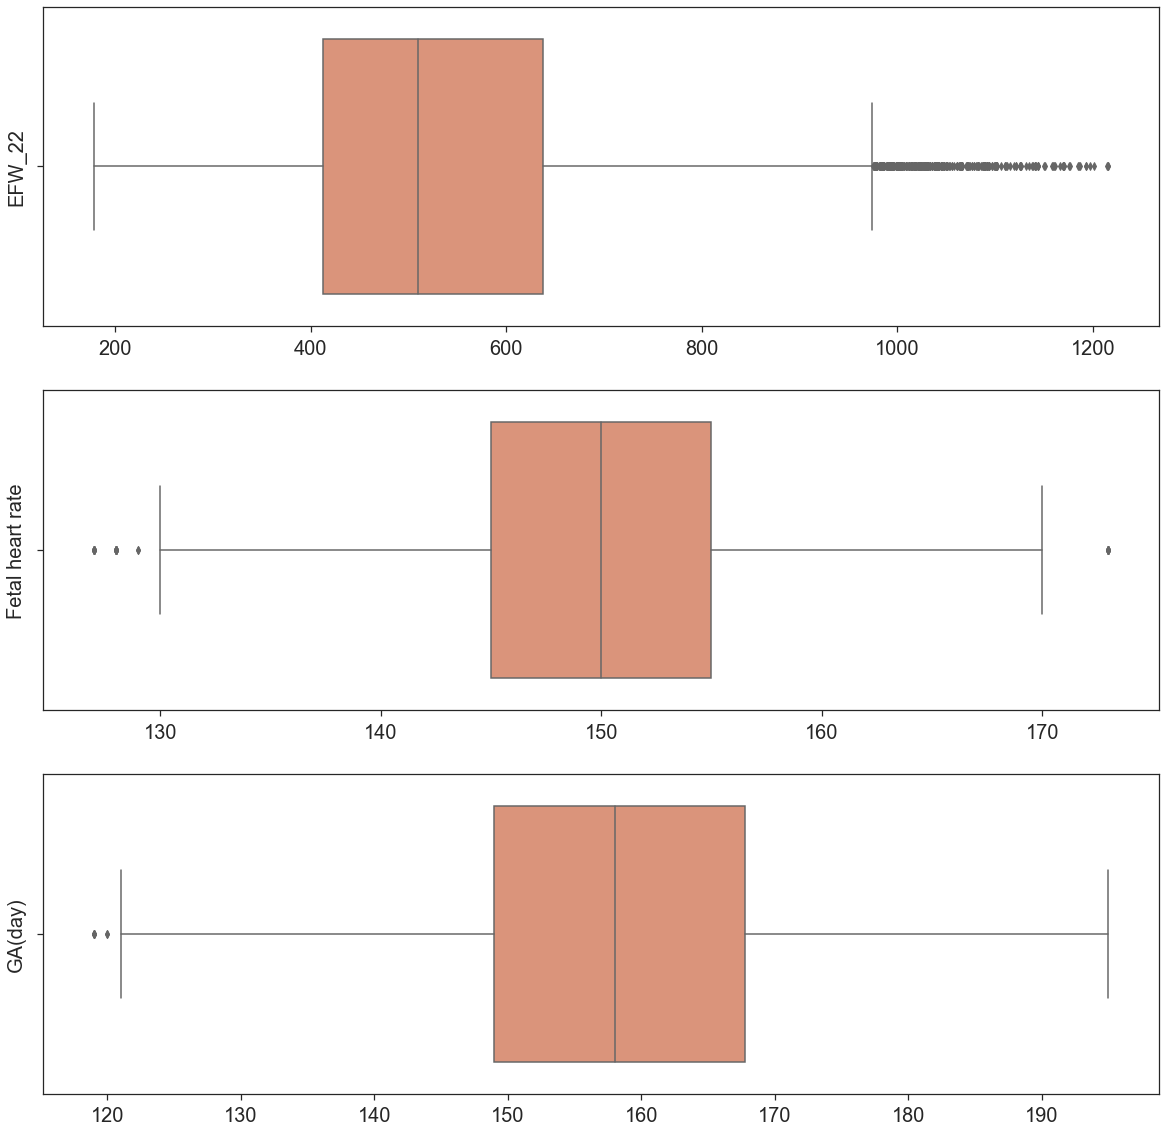

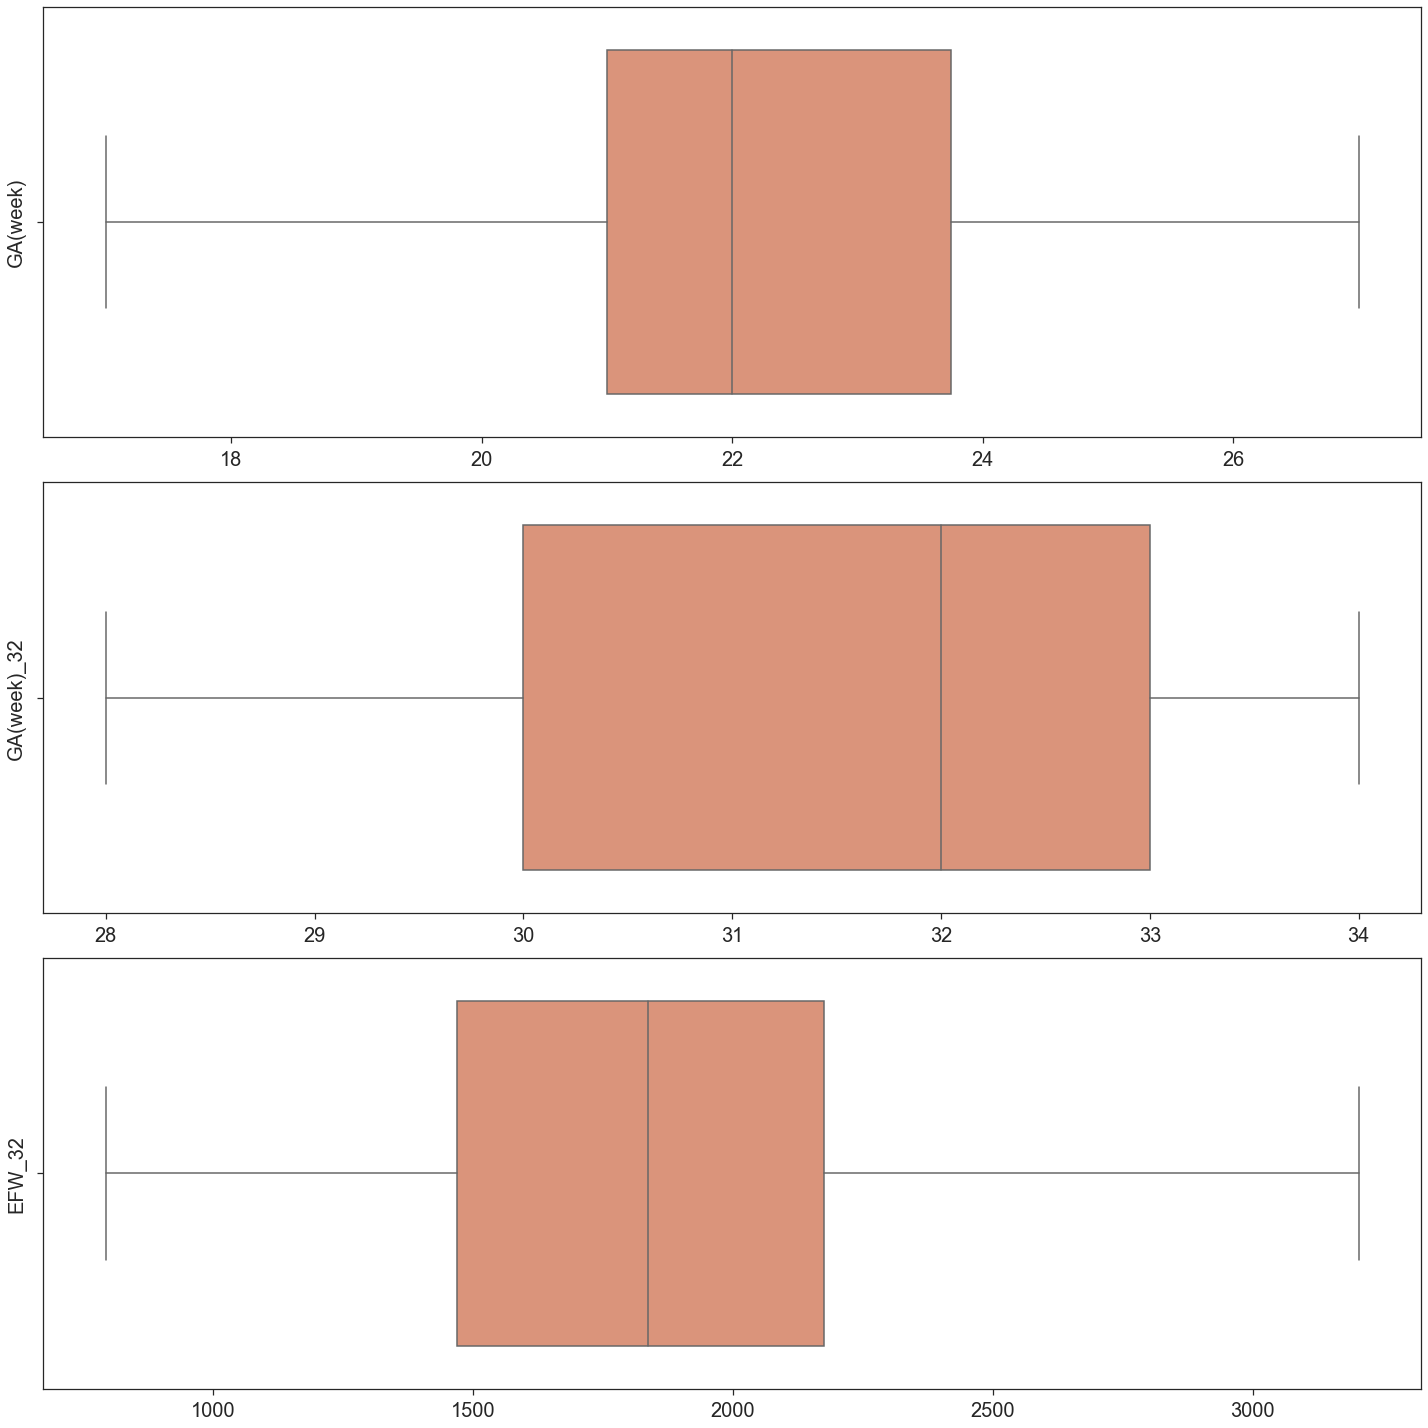

In [89]:
visualize_val_single_df(df_22_32_v4)

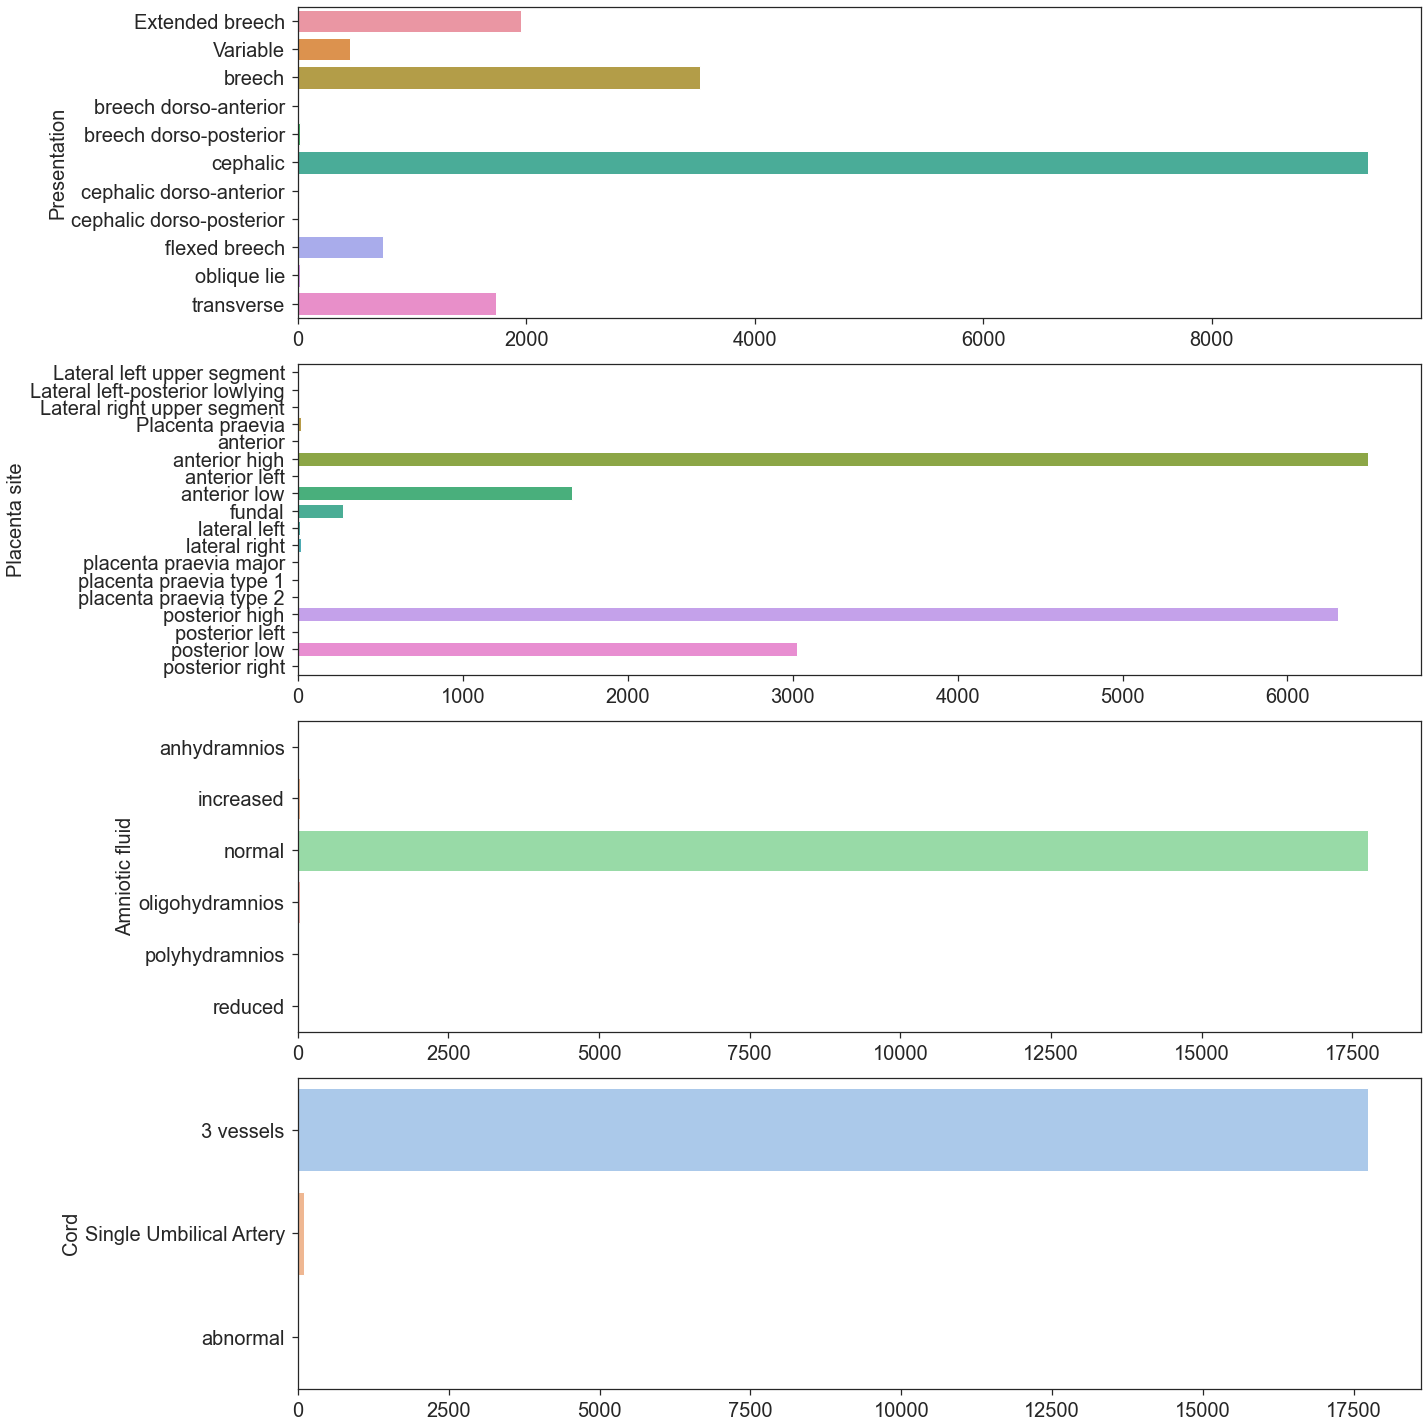

In [90]:
visualize_cat_single_df(df_22_32_v4)

In [38]:
#drop duplicates
df_22_32_v4.drop_duplicates(keep='first', inplace=True)

In [39]:
get_df_details(df_22_32_v4)

Total Scans: 19160
Unique Patients: 9105


## Prediction 22 -> 32

# Model Training Data 

## Pycaret

1. Humerus + Fetal heart rate -> not null
    - Shape: (2468, 47)
    - RMSE: 211.8449 
2. Use Fetal heart rate only
    - Shape: (2649, 46)
    - RMSE: 208.8975
3. Use Humerus 
    - Shape: (10492, 48)
    - RMSE: 213.2135
    - R2: 0.7838
4. Drop both:
    - Shape: (19425, 47)
    - RMSE: 215.4875	
    - R2: 0.7814
    
5. Use GA(week)_32 only:
    - Shape: (19425, 2)
    - RMSE: 247.2611
    - R2: 0.7123
    
** These results are so good due to GA_Week32.


think about how to restate the problem statement

In [40]:
from pycaret.regression import *

In [41]:
# Fetal heart rate - R2 = -0.00036 (Bad)
# Humerus - R2 = 0.0092 (Bad)

# df_train_22_32 = df_22_32_v4[~df_22_32_v4['Humerus'].isnull()]
# df_train_22_32 = df_22_32_v4[~df_22_32_v4['Fetal heart rate'].isnull()]

df_train_22_32 = df_22_32_v4.drop(['Humerus', 'Fetal heart rate'], axis=1).drop(['Examination date', 'df_cat'], axis=1)

# df_train_22_32 = df_train_22_32.drop(['Hospital no.'], axis=1)
# df_train_22_32 = pd.get_dummies(df_train_22_32, drop_first=True)

In [42]:
df_train_22_32.columns

Index(['Hospital no.', 'BPD', 'HC', 'TCD', 'AC', 'CM', 'FL', 'EFW_22',
       'Presentation', 'Placenta site', 'Amniotic fluid', 'Cord',
       'EFW Formulae', 'GA(day)', 'GA(week)', 'GA(week)_32', 'EFW_32'],
      dtype='object')

In [43]:
import re
def custom_cv(df, df_patient_list, model, target):
    kf = KFold(n_splits=10)

    r2_list =[]
    rmse_list = []
    
    dummy_cols = df.select_dtypes(include=['category', 'object']).columns
    dummy_cols = list(set(dummy_cols) - set(['Hospital no.']) )
    df = pd.get_dummies(df, columns=dummy_cols)
    
    df = df.rename(columns = lambda x:re.sub('[^\sA-Za-z0-9_]+', '', x))
    
    for train_index, test_index in kf.split(df_patient_list):
        train_no = df_patient_list.loc[train_index]
        test_no = df_patient_list.loc[test_index]

        train_df = df[df['Hospital no'].isin(train_no['Unique Hos no.'])]
        test_df = df[df['Hospital no'].isin(test_no['Unique Hos no.'])]

        #drop
        train_df = train_df.drop(['Hospital no'],axis=1)
        test_df =  test_df.drop(['Hospital no'],axis=1)
        
        model.fit(train_df.drop(target, axis=1), train_df[target])

        y_true = test_df[target]
        y_pred = model.predict(test_df.drop(target, axis=1))

        r2_list.append(r2_score(y_true, y_pred))
        rmse_list.append(math.sqrt(mean_squared_error(y_true, y_pred)))
        
    df_result = pd.DataFrame(zip(r2_list, rmse_list), columns=['R2', 'RMSE'])
    
    new_row = pd.Series(data={'R2': df_result['R2'].mean(), 'RMSE':df_result['RMSE'].mean()}, name='Mean')
    df_result = df_result.append(new_row)
    
    new_row = pd.Series(data={'R2': df_result['R2'].std(), 'RMSE':df_result['RMSE'].std()}, name='Std')
    df_result = df_result.append(new_row)
    
    return df_result

In [44]:
#lasso #why? because pycaret result shows this is the best

patient_list = list(df_train_22_32['Hospital no.'].unique())
df_patient_list = pd.DataFrame(patient_list, columns=['Unique Hos no.'])
custom_cv(df_train_22_32, df_patient_list, Lasso(), 'EFW_32')

,R2,RMSE
0,0.787281,215.726707
1,0.778305,224.267686
2,0.772597,220.044676
3,0.743947,239.365156
4,0.754844,223.829848
5,0.780721,209.401130
6,0.781470,217.441937
7,0.815332,191.019411
8,0.805072,199.603827
9,0.808623,200.182820


## PyCaret

### Functions

In [45]:
def filter_feature(df, col_test, target, df_result = pd.DataFrame(columns=['Model', 'R2', 'RMSE', 'Feature Removed', 'Help?', 'Comments'])):
    
    '''
    if the features affect >=0.01 r2, only that it get accepted.
    '''
    r2_tolerate = 0.01
    
    #get threshold
    r2_threshold, rmse_threshold = 0, 0

    df = df[col_test + [target]] 
    
    exp_reg101 = setup(data = df, target = target , session_id=12, silent=True) 
    compare_models()
    score = pull()

    best_row = score.iloc[0]

    model_threshold = best_row['Model']
    r2_threshold = best_row['R2']
    rmse_threshold = best_row['RMSE']

    df_add = pd.DataFrame([[model_threshold, r2_threshold, rmse_threshold, 'None', 'None', 'Threshold']], 
                          columns=['Model', 'R2', 'RMSE', 'Feature Removed', 'Help?', 'Comments'])
    df_result = df_result.append(df_add)
    
    #get results
    cols_to_use = []
    for index, col in enumerate(col_test):
        col_to_use = col_test[:index] + col_test[index+1:] + [target]
        exp_reg101 = setup(data = df[col_to_use], target = target , session_id=12, silent=True) 
        compare_models()
        score = pull()

        best_row = score.iloc[0]

        best_model = best_row['Model']
        best_r2 = best_row['R2']
        best_rmse = best_row['RMSE']
        
        help_ = (r2_threshold-r2_tolerate>best_r2 and rmse_threshold<best_rmse) #bench mark r2 > test r2, means that the feature removed aid
        
        if help_:
            cols_to_use.append(col)
        
        df_add = pd.DataFrame([[best_model, best_r2, best_rmse, col, help_, 'Compare']], 
                              columns=['Model', 'R2', 'RMSE', 'Feature Removed', 'Help?', 'Comments'])
        
        df_result = df_result.append(df_add)
        
    print('DONE!')
    return df_result.reset_index(drop=True), cols_to_use

In [46]:
# df_train_22_32.columns

In [47]:
df_train_22_32.describe()

,BPD,HC,TCD,AC,CM,FL,EFW_22,GA(day),GA(week),GA(week)_32,EFW_32
count,19160.000000,19160.000000,19160.000000,19160.000000,19160.000000,19160.000000,19160.000000,19160.000000,19160.000000,19160.000000,19160.000000
mean,54.243366,202.006936,24.064541,178.855251,5.187563,38.596999,537.693580,158.597443,22.226461,31.302714,1833.483768
std,6.147294,22.118860,2.970743,21.748520,1.339355,5.315668,174.764767,13.295974,1.909295,2.042380,461.373546
min,36.400000,135.900000,15.800000,114.700000,1.700000,22.500000,178.000000,119.000000,17.000000,28.000000,436.000000
25%,49.900000,186.700000,21.900000,163.800000,4.200000,35.000000,411.000000,149.000000,21.000000,30.000000,1461.000000
50%,53.800000,200.600000,23.800000,177.800000,5.000000,38.400000,509.000000,158.000000,22.000000,32.000000,1831.000000
75%,58.300000,217.000000,26.000000,193.400000,6.100000,42.200000,636.000000,168.000000,24.000000,33.000000,2173.000000
max,73.300000,270.200000,33.300000,246.600000,9.400000,54.900000,1229.000000,195.000000,27.000000,34.000000,3585.000000


In [48]:
#Pycaret datasets

patient_list = list(df_train_22_32['Hospital no.'].unique())
ten_per = len(patient_list)//10
test_patient, train_patient = patient_list[-ten_per:], patient_list[:-ten_per]

df_train_22_32_90 = df_train_22_32.loc[df_train_22_32['Hospital no.'].isin(train_patient), :] #use this to train
df_test_22_32_10 = df_train_22_32.loc[df_train_22_32['Hospital no.'].isin(test_patient), :]

df_train_22_32_90.drop('Hospital no.', axis=1, inplace=True)
df_test_22_32_10.drop('Hospital no.', axis=1, inplace=True)

In [49]:
df_train_22_32_90.columns

Index(['BPD', 'HC', 'TCD', 'AC', 'CM', 'FL', 'EFW_22', 'Presentation',
       'Placenta site', 'Amniotic fluid', 'Cord', 'EFW Formulae', 'GA(day)',
       'GA(week)', 'GA(week)_32', 'EFW_32'],
      dtype='object')

In [462]:
#used all (benchmark)
exp_reg101 = setup(data = df_train_22_32_90, target = 'EFW_32', session_id=12, silent=True) 

,Description,Value
0,session_id,12
1,Target,EFW_32
2,Original Data,"(17720, 16)"
3,Missing Values,False
4,Numeric Features,10
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(12403, 49)"


In [463]:
len(df_train_22_32_90.columns)

16

In [426]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,163.4267,47243.2267,217.2940,0.7795,0.1208,0.0927,0.0960
br,Bayesian Ridge,164.0981,48082.3456,219.2280,0.7756,0.1231,0.0935,0.0780
lasso,Lasso Regression,164.0709,48072.3867,219.2062,0.7756,0.1230,0.0935,0.0400
ridge,Ridge Regression,164.1494,48111.9406,219.2958,0.7755,0.1231,0.0935,0.0220
lr,Linear Regression,164.1999,48138.8996,219.3577,0.7753,0.1232,0.0935,0.7410
gbr,Gradient Boosting Regressor,166.1057,49127.5795,221.5889,0.7707,0.1239,0.0947,0.6820
omp,Orthogonal Matching Pursuit,166.2953,49329.3297,222.0421,0.7698,0.1247,0.0948,0.0240
en,Elastic Net,167.9051,50014.8109,223.6016,0.7666,0.1254,0.0962,0.0610
rf,Random Forest Regressor,171.2165,51786.4412,227.5039,0.7583,0.1273,0.0974,1.9930
et,Extra Trees Regressor,176.0325,54795.3413,234.0177,0.7442,0.1316,0.1001,1.7220


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

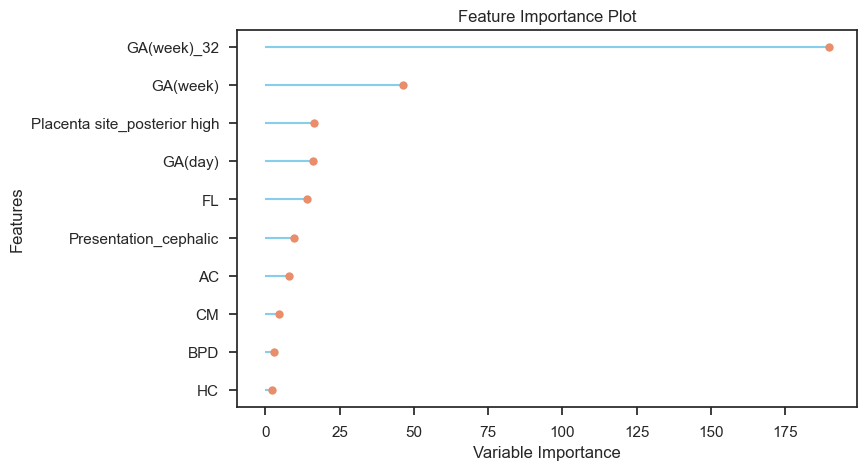

In [464]:
model_ = create_model('lasso')
plot_model(model_, plot='feature')

In [452]:
df_train_22_32_90.columns

Index(['BPD', 'HC', 'TCD', 'AC', 'CM', 'FL', 'EFW_22', 'Presentation',
       'Placenta site', 'Amniotic fluid', 'Cord', 'EFW Formulae', 'GA(day)',
       'GA(week)', 'GA(week)_32', 'EFW_32'],
      dtype='object')

## LGB weirds

In [453]:
col_test_22_32 = ['GA(week)_32', 'GA(week)', 'FL', 'AC', 'CM', 'EFW_22', 'BPD', 'HC']
# col_test_22_32 = ['GA(week)_32', 'GA(week)', 'FL', 'AC', 'CM', 'Placenta site', 'Presentation']
df_result_22_32, cols_to_use_22_32 = filter_feature(df_train_22_32_90, col_test_22_32, 'EFW_32')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,164.0432,47694.4461,218.3027,0.7765,0.1228,0.0934,0.0570
br,Bayesian Ridge,164.1455,48151.1508,219.3301,0.7743,0.1242,0.0939,0.0080
lasso,Lasso Regression,164.1198,48153.4574,219.3349,0.7743,0.1242,0.0938,0.0090
lr,Linear Regression,164.1484,48151.1855,219.3302,0.7743,0.1242,0.0939,0.0230
lar,Least Angle Regression,164.1484,48151.1827,219.3302,0.7743,0.1242,0.0939,0.0130
ridge,Ridge Regression,164.1479,48151.1676,219.3302,0.7743,0.1242,0.0939,0.0070
gbr,Gradient Boosting Regressor,165.2596,48739.6666,220.6578,0.7715,0.1245,0.0945,0.3150
en,Elastic Net,171.4677,52405.1105,228.8310,0.7544,0.1297,0.0988,0.0100
rf,Random Forest Regressor,175.8673,54198.0937,232.7021,0.7461,0.1310,0.1002,1.0460
huber,Huber Regressor,179.7016,56797.8318,238.2526,0.7338,0.1348,0.1032,0.0870


DONE!


In [454]:
df_result_22_32

,Model,R2,RMSE,Feature Removed,Help?,Comments
0,Light Gradient Boosting Machine,0.7767,218.1795,None,None,Threshold
1,Linear Regression,0.0728,444.8766,GA(week)_32,True,Compare
2,Light Gradient Boosting Machine,0.7344,237.9493,GA(week),True,Compare
3,Light Gradient Boosting Machine,0.7765,218.2211,FL,False,Compare
4,Light Gradient Boosting Machine,0.7758,218.5540,AC,False,Compare
5,Light Gradient Boosting Machine,0.7758,218.5982,CM,False,Compare
6,Light Gradient Boosting Machine,0.7773,217.8855,EFW_22,False,Compare
7,Light Gradient Boosting Machine,0.7771,217.9381,BPD,False,Compare
8,Light Gradient Boosting Machine,0.7765,218.3027,HC,False,Compare


In [455]:
cols_to_use_22_32

['GA(week)_32', 'GA(week)']

In [456]:
col_test_22_32_v2 = ['GA(week)_32', 'GA(week)']

df_result_22_32_v2, cols_to_use_22_32_v2 = filter_feature(df_train_22_32_90, col_test_22_32_v2, 'EFW_32')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,185.7125,61096.6405,247.0355,0.7135,0.1398,0.1069,0.0070
rf,Random Forest Regressor,185.7155,61100.4634,247.0427,0.7135,0.1398,0.1069,0.0980
lightgbm,Light Gradient Boosting Machine,185.7124,61096.6384,247.0355,0.7135,0.1398,0.1069,0.0300
et,Extra Trees Regressor,185.7125,61096.6405,247.0355,0.7135,0.1398,0.1069,0.0670
gbr,Gradient Boosting Regressor,185.7124,61096.6384,247.0355,0.7135,0.1398,0.1069,0.0460
lar,Least Angle Regression,186.0055,61215.9410,247.2840,0.7130,0.1400,0.1071,0.0060
omp,Orthogonal Matching Pursuit,186.0055,61215.9418,247.2840,0.7130,0.1400,0.1071,0.0070
br,Bayesian Ridge,186.0052,61215.9406,247.2840,0.7130,0.1400,0.1071,0.0070
ridge,Ridge Regression,186.0053,61215.9352,247.2840,0.7130,0.1400,0.1071,0.0060
lasso,Lasso Regression,185.9977,61216.1738,247.2849,0.7130,0.1400,0.1071,0.0080


DONE!


In [457]:
df_result_22_32_v2

,Model,R2,RMSE,Feature Removed,Help?,Comments
0,Gradient Boosting Regressor,0.7134,247.0714,None,None,Threshold
1,Linear Regression,-0.0007,462.1937,GA(week)_32,True,Compare
2,Decision Tree Regressor,0.7135,247.0355,GA(week),False,Compare


In [458]:
cols_to_use_22_32_v2

['GA(week)_32']

### Lasso good

In [465]:
#Based on feature importances in lasso, stuff that worth to test are:
#Prediction on EFW_32: 'GA(week)_32', 'GA(week)', 'FL', 'Placenta site', 'AC', 'Presentation', 'CM'. (GA_day remove since it's the same with GA(week)))
#Prediction on EFW_32: 'GA(week)', 'AC', 'EFW_22', 'BPD', 'FL', 'CM', 'HC', 'GA(week)_32' #day and week are the same
col_test_22_32 = ['GA(week)_32', 'GA(week)', 'FL', 'Placenta site', 'AC', 'Presentation', 'CM']
df_result_22_32, cols_to_use_22_32 = filter_feature(df_train_22_32_90, col_test_22_32, 'EFW_32')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,164.5640,47899.7892,218.7807,0.7755,0.1230,0.0938,0.0650
br,Bayesian Ridge,164.5323,48199.1647,219.4388,0.7741,0.1241,0.0940,0.0380
ridge,Ridge Regression,164.5495,48190.4703,219.4195,0.7741,0.1240,0.0940,0.0200
lr,Linear Regression,164.5883,48198.3871,219.4377,0.7741,0.1240,0.0940,0.0370
lar,Least Angle Regression,164.5926,48200.6244,219.4428,0.7741,0.1240,0.0940,0.0220
lasso,Lasso Regression,164.4677,48229.2215,219.5052,0.7739,0.1243,0.0940,0.0230
gbr,Gradient Boosting Regressor,165.6420,48874.8389,220.9585,0.7709,0.1245,0.0946,0.3500
omp,Orthogonal Matching Pursuit,166.6645,49291.8290,221.9195,0.7689,0.1258,0.0955,0.0340
en,Elastic Net,171.3885,52346.5484,228.7011,0.7547,0.1297,0.0988,0.0380
rf,Random Forest Regressor,177.5189,55306.4817,235.0659,0.7408,0.1320,0.1010,1.0330


DONE!


In [466]:
df_result_22_32

,Model,R2,RMSE,Feature Removed,Help?,Comments
0,Light Gradient Boosting Machine,0.7764,218.3071,None,None,Threshold
1,Lasso Regression,0.0730,444.8302,GA(week)_32,True,Compare
2,Light Gradient Boosting Machine,0.7293,240.1947,GA(week),True,Compare
3,Light Gradient Boosting Machine,0.7714,220.7198,FL,False,Compare
4,Light Gradient Boosting Machine,0.7754,218.8135,Placenta site,False,Compare
5,Light Gradient Boosting Machine,0.7513,230.1955,AC,True,Compare
6,Light Gradient Boosting Machine,0.7772,217.9363,Presentation,False,Compare
7,Light Gradient Boosting Machine,0.7755,218.7807,CM,False,Compare


In [467]:
cols_to_use_22_32

['GA(week)_32', 'GA(week)', 'AC']

In [468]:
col_test_22_32_v2 = ['GA(week)_32', 'GA(week)', 'AC']

df_result_22_32_v2, cols_to_use_22_32_v2 = filter_feature(df_train_22_32_90, col_test_22_32_v2, 'EFW_32')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,185.6837,61113.8087,247.0714,0.7134,0.1397,0.1069,0.0760
lasso,Lasso Regression,185.9447,61172.3742,247.1958,0.7132,0.1400,0.1071,0.0080
ridge,Ridge Regression,185.9514,61171.8082,247.1943,0.7132,0.1400,0.1071,0.0090
lar,Least Angle Regression,185.9515,61171.8120,247.1943,0.7132,0.1400,0.1071,0.0120
br,Bayesian Ridge,185.9511,61171.8121,247.1943,0.7132,0.1400,0.1071,0.0070
lr,Linear Regression,185.9515,61171.8094,247.1943,0.7132,0.1400,0.1071,0.0220
huber,Huber Regressor,185.9184,61185.4521,247.2249,0.7131,0.1399,0.1070,0.0230
omp,Orthogonal Matching Pursuit,186.0055,61215.9415,247.2840,0.7130,0.1400,0.1071,0.0080
lightgbm,Light Gradient Boosting Machine,186.0361,61275.0001,247.4014,0.7127,0.1399,0.1071,0.0360
dt,Decision Tree Regressor,186.0954,61325.5418,247.5017,0.7125,0.1400,0.1071,0.0230


DONE!


In [469]:
df_result_22_32_v2

,Model,R2,RMSE,Feature Removed,Help?,Comments
0,Linear Regression,0.7689,221.9195,None,None,Threshold
1,Linear Regression,0.0680,446.0419,GA(week)_32,True,Compare
2,Gradient Boosting Regressor,0.7226,243.1046,GA(week),True,Compare
3,Gradient Boosting Regressor,0.7134,247.0714,AC,True,Compare


In [470]:
cols_to_use_22_32_v2 #finalized

['GA(week)_32', 'GA(week)', 'AC']

In [50]:
#finalized col: ['GA(week)_32', 'GA(week)', 'AC']
exp_reg101 = setup(data = df_train_22_32_90[['GA(week)_32', 'GA(week)', 'AC'] + ['EFW_32']], target = 'EFW_32', session_id=12, silent=True)

,Description,Value
0,session_id,12
1,Target,EFW_32
2,Original Data,"(17720, 4)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(12403, 3)"


In [51]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,166.6645,49291.8297,221.9195,0.7689,0.1258,0.0955,0.7140
lasso,Lasso Regression,166.6301,49293.6523,221.9231,0.7689,0.1258,0.0954,0.0080
ridge,Ridge Regression,166.6640,49291.8227,221.9195,0.7689,0.1258,0.0955,0.0070
lar,Least Angle Regression,166.6645,49291.8295,221.9195,0.7689,0.1258,0.0955,0.0120
br,Bayesian Ridge,166.6633,49291.8243,221.9195,0.7689,0.1258,0.0955,0.0070
huber,Huber Regressor,166.5873,49303.9912,221.9466,0.7689,0.1257,0.0954,0.0460
gbr,Gradient Boosting Regressor,166.9677,49558.5621,222.5006,0.7677,0.1255,0.0955,0.1610
lightgbm,Light Gradient Boosting Machine,167.4839,49573.0184,222.5541,0.7676,0.1254,0.0956,0.0590
en,Elastic Net,172.1379,52729.9324,229.5397,0.7529,0.1302,0.0993,0.0070
knn,K Neighbors Regressor,182.9826,58389.6027,241.5766,0.7262,0.1353,0.1043,0.0120


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [52]:
model_ = create_model('ridge')#best

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,171.6667,52047.0156,228.1382,0.7501,0.1328,0.1002
1,167.0219,48956.6016,221.2614,0.7670,0.1269,0.0959
2,160.7378,44653.0234,211.3126,0.7975,0.1183,0.0908
3,166.4496,50382.0078,224.4594,0.7621,0.1233,0.0937
4,172.4684,52696.4297,229.5570,0.7446,0.1284,0.0979
5,164.6898,47468.6641,217.8730,0.7736,0.1221,0.0937
6,157.3031,44390.3672,210.6902,0.7868,0.1245,0.0924
7,172.4808,52576.8008,229.2963,0.7638,0.1268,0.0966
8,165.2820,48521.1758,220.2752,0.7821,0.1305,0.0980
9,168.5403,51226.1406,226.3319,0.7617,0.1249,0.0955


In [53]:
tuned_model = tune_model(model_, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,171.6647,52047.2188,228.1386,0.7501,0.1328,0.1002
1,167.0179,48955.4258,221.2587,0.7670,0.1269,0.0959
2,160.7383,44653.7891,211.3144,0.7975,0.1183,0.0908
3,166.4516,50383.7852,224.4633,0.7621,0.1233,0.0937
4,172.4666,52695.9102,229.5559,0.7446,0.1284,0.0979
5,164.6813,47466.8555,217.8689,0.7736,0.1221,0.0937
6,157.2976,44389.7617,210.6888,0.7868,0.1245,0.0924
7,172.4798,52578.6953,229.3004,0.7638,0.1268,0.0966
8,165.2787,48520.3086,220.2733,0.7821,0.1305,0.0980
9,168.5341,51226.4570,226.3326,0.7617,0.1249,0.0955


In [54]:
predicted = predict_model(tuned_model, df_test_22_32_10)

In [58]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))*100

In [59]:
y_true = predicted['EFW_32']
y_pred = predicted['Label']

r2 = r2_score(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
mape = MAPE(y_true, y_pred)

In [60]:
print(f'R2: {r2}, RMSE: {rmse}, MAPE: {mape}')

R2: 0.7876132608842134, RMSE: 210.88490037801898, MAPE: 8.953071663837294


In [532]:
final_model = finalize_model(tuned_model)
import datetime
save_model(final_model,'ridge_22_32_malaysia ' + datetime.datetime.now().strftime('%d-%b-%Y'))

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='EFW_32',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy...
                 ('dummy', Dummify(target='EFW_32')),
                 ('fix_perfect', Remove_100(target='EFW_32')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'passthrough'), ('pca', 'passthrou

## df_32 -> df_35 

In [61]:
null_threshold = 400
to_drop = list(df_32_35.loc[:, df_32_35.isnull().sum() > (df_32_35.shape[0] - null_threshold)])
df_32_35_v2 = df_32_35.drop(to_drop, axis=1)
df_32_35_v2 = df_32_35_v2.drop(['PID', 'Case number', 'Exam', 'Fetus', 'EFW centile'], axis=1)

In [62]:
#clean up features that has not null > 15k
#BPD, HC, AC, FL, AF Index, Presentation, Placenta site, amniotic fluid, Estimated fetal weight(type)

df_32_35_v2 = df_32_35_v2[   ~df_32_35_v2['BPD'].isnull() & #30488 
                             ~df_32_35_v2['HC'].isnull() & #30506 
                             ~df_32_35_v2['AC'].isnull() & #30517 
                             ~df_32_35_v2['FL'].isnull() & #30515 
                             ~df_32_35_v2['Presentation'].isnull() &#30160 
                             ~df_32_35_v2['Placenta site'].isnull() & #30004 
                             ~df_32_35_v2['Amniotic fluid'].isnull() & #29937 
                             ~df_32_35_v2['EFW Formulae'].isnull() & #30517 
                             ~df_32_35_v2['AF Index'].isnull()#30517 
                            ]

# df_32_35_v2 = df_32_35_v2[df_32_35_v2['Cord'].isin(['3 vessels', 'Single Umbilical Artery', 'abnormal'])]

In [63]:
#clean up features that has not null > 9k
#PI, RI

df_32_35_v3 = df_32_35_v2[   ~df_32_35_v2['PI'].isnull() & #9583
                             ~df_32_35_v2['RI'].isnull() & #9564
                             ~df_32_35_v2['EDF'].isnull()  #12366 
                            ]

In [64]:
#clean up null
null_threshold = 200
to_drop = list(df_32_35_v3.loc[:, df_32_35_v3.isnull().sum() > (df_32_35_v3.shape[0] - null_threshold)])
df_32_35_v4 = df_32_35_v3.drop(to_drop, axis=1)

df_32_35_v4.drop(['df_cat'], axis=1, inplace=True)

In [65]:
# len(df_32_35_v4['Hospital no.'].unique())

In [66]:
# df_32_35_v4.info()

In [67]:
#cleaning outliers
z_score_list = ['BPD', 'HC', 'TCD', 'AC', 'CM', 'FL','Humerus', 'EFW (clinical)', 'Fetal heart rate', 'GA(day)', 'AF Index',
                'GA(week)', 'PI', 'RI', 'PI (2)', 'RI (2)', 'Cerebro-placental ratio']

df_32_35_v5, cols_affected = clean_outliers_zscore(df_32_35_v4, z_score_list)

In [68]:
df_32_35_v5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8765 entries, 1 to 27787
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Hospital no.             8765 non-null   object        
 1   BPD                      8765 non-null   float64       
 2   HC                       8765 non-null   float64       
 3   TCD                      546 non-null    float64       
 4   AC                       8765 non-null   float64       
 5   FL                       8765 non-null   float64       
 6   Humerus                  349 non-null    float64       
 7   EFW_32                   8765 non-null   float64       
 8   Fetal heart rate         647 non-null    float64       
 9   Presentation             8765 non-null   category      
 10  Placenta site            8765 non-null   category      
 11  AF Index                 8765 non-null   float64       
 12  Amniotic fluid           8765 non

In [69]:
print(cols_affected)

['BPD', 'HC', 'TCD', 'AC', 'FL', 'Humerus', 'Fetal heart rate', 'AF Index', 'PI', 'RI', 'PI (2)', 'RI (2)', 'Cerebro-placental ratio', 'GA(day)', 'GA(week)']


In [70]:
get_df_details(df_32_35_v5)

Total Scans: 8765
Unique Patients: 4524


In [71]:
#remove duplicates
df_32_35_v5.drop_duplicates(keep= 'first', inplace=True)

In [72]:
get_df_details(df_32_35_v5)

Total Scans: 8765
Unique Patients: 4524


In [73]:
# len(df_32_35_v5['Hospital no.'].unique())

## I test the features < 4000 non-null to find whether it's worth to keep

- TCD - R2 = -0.03 (Bad)
- Fetal Heart Rate = -0.02 (Bad)
- Cord = -0.01 (Bad)
- PI (2) = 0.0002 (Bad)
- RI (2) = -0.0003 (Bad)
- Cerebro-placental ratio = 0.02 (Bad)
- Humerus - R2 = 0.1516 (Good)

In [74]:
# df_32_35_v5.info()

In [75]:
# col_test = 'Cerebro-placental ratio'
# df_32_35_train = df_32_35_v5[~df_32_35_v5[col_test].isnull() & #30488 
#                              ~df_32_35_v5['EFW_35'].isnull() ] #30506 

df_32_35_train = df_32_35_v5.drop([  'TCD', 'Fetal heart rate', 'Cord', 
                                     'PI (2)', 'RI (2)', 'Cerebro-placental ratio', 
                                     'Humerus'], axis=1)
df_32_35_train = df_32_35_train.drop(['Examination date'] ,axis=1)
# df_32_35_train = df_32_35_train.drop(['Hospital no.'] ,axis=1)
# df_32_35_train = pd.get_dummies(df_32_35_train, drop_first=True)

In [76]:
df_32_35_train.columns

Index(['Hospital no.', 'BPD', 'HC', 'AC', 'FL', 'EFW_32', 'Presentation',
       'Placenta site', 'AF Index', 'Amniotic fluid', 'PI', 'RI', 'EDF',
       'EFW Formulae', 'GA(day)', 'GA(week)', 'GA(week)_35', 'EFW_35'],
      dtype='object')

In [77]:
df_32_35_train.describe()

,BPD,HC,AC,FL,EFW_32,AF Index,PI,RI,GA(day),GA(week),GA(week)_35,EFW_35
count,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000
mean,80.298905,294.551934,277.615459,60.767268,1887.418939,13.064278,0.941970,0.619542,227.222932,32.029093,36.389618,2750.786309
std,5.293346,17.015365,23.450022,4.581460,418.021542,4.133875,0.145611,0.061779,12.486617,1.763634,1.149011,441.529523
min,63.900000,241.600000,209.800000,46.700000,887.000000,1.400000,0.540000,0.430000,196.000000,28.000000,35.000000,1303.000000
25%,77.000000,283.700000,261.900000,57.800000,1599.000000,10.300000,0.840000,0.580000,219.000000,31.000000,36.000000,2437.000000
50%,80.600000,296.100000,278.800000,61.200000,1889.000000,12.700000,0.940000,0.620000,230.000000,32.000000,36.000000,2730.000000
75%,84.000000,306.300000,293.300000,64.000000,2157.000000,15.500000,1.040000,0.660000,238.000000,34.000000,37.000000,3041.000000
max,94.900000,346.500000,348.600000,74.700000,3441.000000,27.000000,1.410000,0.810000,244.000000,34.000000,41.000000,4596.000000


## Manual CV

In [508]:
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

patient_list = list(df_32_35_train['Hospital no.'].unique())
df_patient_list = pd.DataFrame(patient_list, columns=['Unique Hos no.'])
custom_cv(df_32_35_train, df_patient_list, linear_model.BayesianRidge(), 'EFW_35')

,R2,RMSE
0,0.522934,311.955271
1,0.453204,316.852886
2,0.535431,302.184130
3,0.562958,278.600512
4,0.633792,276.022916
5,0.565821,290.486830
6,0.609624,264.212913
7,0.609040,273.956592
8,0.667682,267.239518
9,0.651998,249.232320


In [78]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

patient_list = list(df_32_35_train['Hospital no.'].unique())
ten_per = len(patient_list)//10
test_patient, train_patient = patient_list[-ten_per:], patient_list[:-ten_per]

In [79]:
df_32_35_train_90 = df_32_35_train.loc[df_32_35_train['Hospital no.'].isin(train_patient), :]
df_32_35_test_10 = df_32_35_train.loc[df_32_35_train['Hospital no.'].isin(test_patient), :]

df_32_35_train_90.drop('Hospital no.', axis=1, inplace=True)
df_32_35_test_10.drop('Hospital no.', axis=1, inplace=True)

In [110]:
# df_32_35_train_90.shape

In [111]:
# len(df_32_35_train_90['Hospital no.'].unique())

In [112]:
# len(df_32_35_train_90['Hospital no.'].unique())

In [113]:
# check_df(df_32_35_train_90)

In [511]:
len(df_32_35_train_90.columns)

17

In [512]:
exp_reg101 = setup(data = df_32_35_train_90, target = 'EFW_35', session_id=12) 

,Description,Value
0,session_id,12
1,Target,EFW_35
2,Original Data,"(8028, 17)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(5619, 51)"


In [513]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,221.2012,82623.3138,287.2897,0.5652,0.1054,0.0820,0.0380
lasso,Lasso Regression,221.1528,82680.4945,287.3810,0.5649,0.1054,0.0819,0.0280
ridge,Ridge Regression,221.7475,82879.2688,287.7381,0.5637,0.1055,0.0821,0.0190
lr,Linear Regression,222.0500,83130.2883,288.1780,0.5624,0.1057,0.0822,0.7800
lightgbm,Light Gradient Boosting Machine,224.1022,83414.0750,288.7437,0.5606,0.1062,0.0831,0.0660
gbr,Gradient Boosting Regressor,224.1109,83587.1716,289.0148,0.5600,0.1062,0.0832,0.3580
omp,Orthogonal Matching Pursuit,223.8773,84393.4071,290.3162,0.5560,0.1064,0.0829,0.0380
huber,Huber Regressor,223.3363,85806.0880,292.7469,0.5482,0.1073,0.0824,0.2860
en,Elastic Net,227.3134,86516.0070,293.9612,0.5449,0.1082,0.0846,0.0580
rf,Random Forest Regressor,233.9348,90557.5412,300.8714,0.5228,0.1106,0.0868,0.8230


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [514]:
model_ = create_model('lasso')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,220.7705,78338.9062,279.8909,0.5892,0.1033,0.0828
1,225.2853,88906.3438,298.1717,0.5971,0.1108,0.0835
2,229.8872,87145.6797,295.2045,0.5361,0.1075,0.0839
3,229.7756,89114.3125,298.5202,0.5698,0.1099,0.0851
4,206.8841,72492.3125,269.2440,0.5859,0.0997,0.0773
5,225.0502,88723.0000,297.8641,0.5334,0.1088,0.0837
6,218.4281,79143.2734,281.3242,0.5821,0.1020,0.0802
7,227.8832,84707.7578,291.0460,0.5532,0.1054,0.0834
8,212.8772,78217.1719,279.6733,0.5561,0.1014,0.0784
9,214.6867,80016.1875,282.8713,0.5463,0.1052,0.0811


In [515]:
df_32_35_train_90.columns

Index(['BPD', 'HC', 'AC', 'FL', 'EFW_32', 'Presentation', 'Placenta site',
       'AF Index', 'Amniotic fluid', 'PI', 'RI', 'EDF', 'EFW Formulae',
       'GA(day)', 'GA(week)', 'GA(week)_35', 'EFW_35'],
      dtype='object')

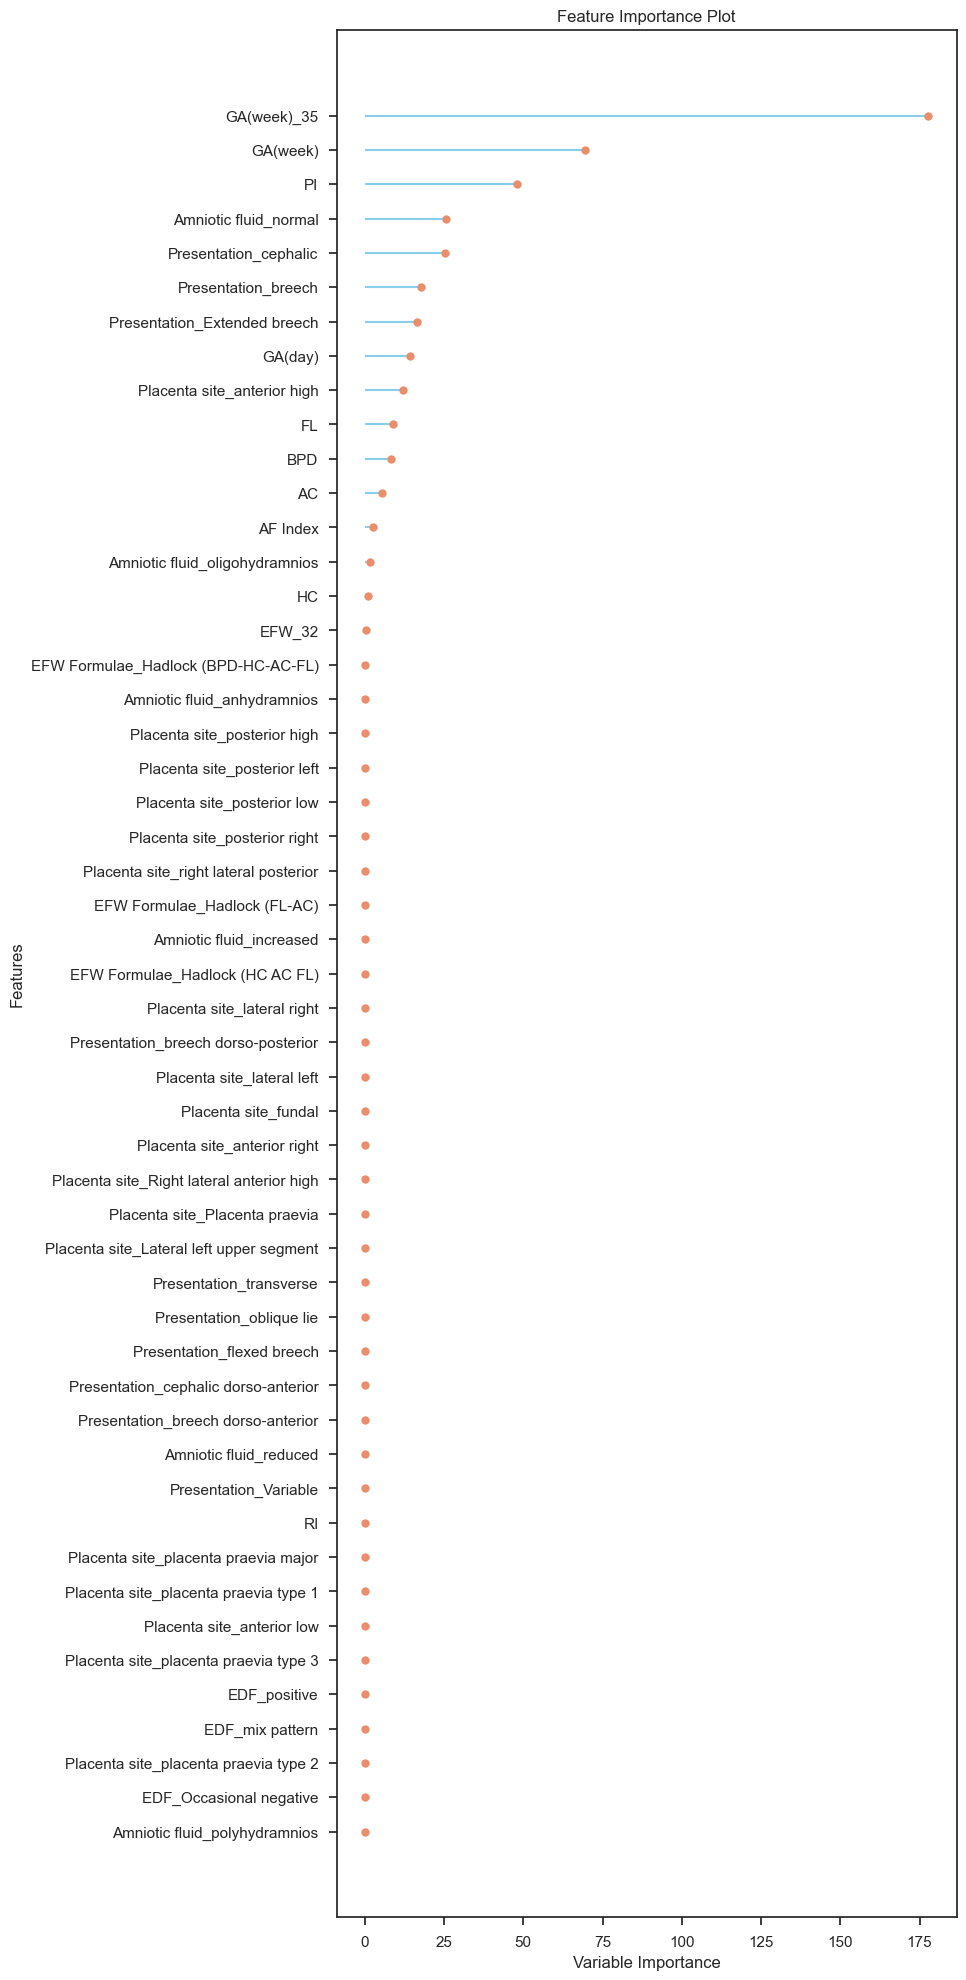

In [516]:
#bayessian
['GA(week)_35', 'GA(week)', 'PI', 'Presentation', 'Placenta site', 'Amniotic fluid', 'EFW Formulae', 'GA(day)', 'FL', 'EDF', 'BPD']
#lasso
['GA(week)_35', 'GA(week)', 'Amniotic fluid', 'Presentation', 'PI', 'GA(day)', 'Placenta site', 'FL', 'BPD', 'AC', 'AF Index']
#we pick lasso one because it is more logical.
['GA(week)_35', 'GA(week)', 'Amniotic fluid', 'Presentation', 'PI', 'Placenta site', 'FL', 'BPD', 'AC', 'AF Index']
#removed GA(day) as it is same with GA(week)

plot_model(model_, plot='feature_all')

In [517]:
col_test_32_35 = ['GA(week)_35', 'GA(week)', 'Amniotic fluid', 'Presentation', 'PI', 'Placenta site', 'FL', 'BPD', 'AC', 'AF Index']
df_result_32_35, cols_to_use_32_35 = filter_feature(df_32_35_train_90, col_test_32_35, 'EFW_35')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,224.7716,83688.6496,289.1908,0.5594,0.1063,0.0834,0.2370
br,Bayesian Ridge,223.3804,83818.4676,289.3439,0.5589,0.1060,0.0827,0.0130
lasso,Lasso Regression,223.3651,83863.7273,289.4130,0.5588,0.1061,0.0827,0.0110
ridge,Ridge Regression,223.8241,84102.2086,289.8361,0.5574,0.1062,0.0829,0.0080
lr,Linear Regression,224.0344,84325.7688,290.2271,0.5561,0.1063,0.0829,0.0240
lightgbm,Light Gradient Boosting Machine,225.3084,84396.9083,290.4285,0.5553,0.1067,0.0835,0.0620
omp,Orthogonal Matching Pursuit,228.8772,87227.3471,295.1412,0.5411,0.1084,0.0849,0.0090
en,Elastic Net,236.0253,90652.7656,300.8983,0.5233,0.1110,0.0881,0.0090
huber,Huber Regressor,233.7888,92068.8486,303.2889,0.5155,0.1112,0.0865,0.2090
rf,Random Forest Regressor,237.8731,93495.6612,305.7306,0.5070,0.1123,0.0882,0.7820


DONE!


In [518]:
df_result_32_35

,Model,R2,RMSE,Feature Removed,Help?,Comments
0,Gradient Boosting Regressor,0.5599,288.9965,None,None,Threshold
1,Lasso Regression,0.3375,354.6686,GA(week)_35,True,Compare
2,Gradient Boosting Regressor,0.4212,331.3600,GA(week),True,Compare
3,Lasso Regression,0.5592,289.2779,Amniotic fluid,False,Compare
4,Lasso Regression,0.5582,289.6013,Presentation,False,Compare
5,Lasso Regression,0.5591,289.2985,PI,False,Compare
6,Bayesian Ridge,0.5601,288.9525,Placenta site,False,Compare
7,Bayesian Ridge,0.5478,292.9547,FL,True,Compare
8,Lasso Regression,0.5489,292.6370,BPD,True,Compare
9,Lasso Regression,0.4875,311.9156,AC,True,Compare


In [519]:
print(cols_to_use_32_35) #all here refer to 32 if not specified

['GA(week)_35', 'GA(week)', 'FL', 'BPD', 'AC']


In [520]:
df_result_32_35_v2, cols_to_use_32_35_v2 = filter_feature(df_32_35_train_90, cols_to_use_32_35, 'EFW_35')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,248.3708,99793.3878,315.7959,0.4746,0.1158,0.0922,0.0980
lr,Linear Regression,247.4137,100002.4992,316.1056,0.4737,0.1156,0.0917,0.0210
lasso,Lasso Regression,247.4757,100004.9742,316.1087,0.4737,0.1156,0.0918,0.0080
ridge,Ridge Regression,247.4152,100002.4938,316.1056,0.4737,0.1156,0.0917,0.0080
lar,Least Angle Regression,247.4137,100002.5045,316.1056,0.4737,0.1156,0.0917,0.0090
br,Bayesian Ridge,247.4239,100002.5991,316.1056,0.4737,0.1156,0.0917,0.0070
huber,Huber Regressor,246.7116,100300.0117,316.5698,0.4721,0.1155,0.0909,0.0270
lightgbm,Light Gradient Boosting Machine,251.4587,102041.1903,319.3323,0.4627,0.1170,0.0932,0.0240
en,Elastic Net,257.9834,106260.6695,325.8070,0.4412,0.1199,0.0963,0.0070
rf,Random Forest Regressor,272.8582,119574.4159,345.7128,0.3703,0.1269,0.1014,0.2840


DONE!


In [521]:
df_result_32_35_v2

,Model,R2,RMSE,Feature Removed,Help?,Comments
0,Linear Regression,0.5560,290.3162,None,None,Threshold
1,Linear Regression,0.3337,355.6765,GA(week)_35,True,Compare
2,Gradient Boosting Regressor,0.4040,336.2699,GA(week),True,Compare
3,Gradient Boosting Regressor,0.5439,294.2250,FL,True,Compare
4,Linear Regression,0.5451,293.8762,BPD,True,Compare
5,Gradient Boosting Regressor,0.4746,315.7959,AC,True,Compare


In [522]:
cols_to_use_32_35_v2 

['GA(week)_35', 'GA(week)', 'FL', 'BPD', 'AC']

In [81]:
cols_to_use_32_35_v2  = ['GA(week)_35', 'GA(week)', 'FL', 'BPD', 'AC']
exp_reg101 = setup(data = df_32_35_train_90[cols_to_use_32_35_v2 + ['EFW_35']], target = 'EFW_35', session_id=12) 

,Description,Value
0,session_id,12
1,Target,EFW_35
2,Original Data,"(8028, 6)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(5619, 5)"


In [82]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,223.8773,84393.4023,290.3162,0.5560,0.1064,0.0829,0.7130
lasso,Lasso Regression,223.9701,84395.6547,290.3200,0.5560,0.1064,0.0829,0.0080
ridge,Ridge Regression,223.8797,84393.3953,290.3161,0.5560,0.1064,0.0829,0.0070
lar,Least Angle Regression,223.8773,84393.4063,290.3162,0.5560,0.1064,0.0829,0.0280
br,Bayesian Ridge,223.8940,84393.4838,290.3163,0.5560,0.1064,0.0829,0.0100
gbr,Gradient Boosting Regressor,225.4620,84412.1285,290.4247,0.5556,0.1067,0.0837,0.1030
lightgbm,Light Gradient Boosting Machine,227.4690,86003.6860,293.1435,0.5471,0.1077,0.0844,0.0340
huber,Huber Regressor,228.0426,89170.7766,298.2107,0.5319,0.1094,0.0842,0.0460
en,Elastic Net,236.2484,90851.8672,301.2283,0.5223,0.1111,0.0882,0.0130
rf,Random Forest Regressor,241.0213,96093.4079,309.9320,0.4933,0.1137,0.0894,0.4180


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [83]:
model_ = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,223.0955,79862.2109,282.5990,0.5812,0.1041,0.0835
1,227.1484,90271.7969,300.4527,0.5909,0.1116,0.0841
2,231.8161,88420.9844,297.3567,0.5293,0.1085,0.0846
3,235.2220,92779.1328,304.5967,0.5521,0.1122,0.0870
4,208.3020,72924.2578,270.0449,0.5834,0.0995,0.0776
5,228.4436,90509.9531,300.8487,0.5240,0.1104,0.0851
6,219.3456,80308.4531,283.3875,0.5760,0.1026,0.0806
7,232.0601,87478.0078,295.7668,0.5386,0.1070,0.0849
8,214.6296,79743.2344,282.3885,0.5474,0.1022,0.0790
9,218.7103,81635.9922,285.7201,0.5371,0.1062,0.0825


In [84]:
tuned_model = tune_model(model_, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,223.0955,79862.2031,282.5990,0.5812,0.1041,0.0835
1,227.1483,90271.7734,300.4526,0.5909,0.1116,0.0841
2,231.8161,88421.0000,297.3567,0.5293,0.1085,0.0846
3,235.2220,92779.1172,304.5966,0.5521,0.1122,0.0870
4,208.3019,72924.2500,270.0449,0.5834,0.0995,0.0776
5,228.4436,90509.9609,300.8487,0.5240,0.1104,0.0851
6,219.3455,80308.4453,283.3875,0.5760,0.1026,0.0806
7,232.0600,87477.9922,295.7668,0.5386,0.1070,0.0849
8,214.6296,79743.2188,282.3884,0.5474,0.1022,0.0790
9,218.7102,81636.0000,285.7202,0.5371,0.1062,0.0825


In [85]:
predicted = predict_model(tuned_model, df_32_35_test_10)
y_true = predicted['EFW_35']
y_pred = predicted['Label']

r2 = r2_score(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
mape = MAPE(y_true, y_pred)

print(f'R2: {r2}, RMSE: {rmse}, MAPE:{mape}')


R2: 0.6382310767573226, RMSE: 254.11437077917765, MAPE:7.5731150726552094


In [528]:
final_model = finalize_model(tuned_model)
import datetime
save_model(final_model,'linear_regression_32_35_malaysia ' + datetime.datetime.now().strftime('%d-%b-%Y'))

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='EFW_35',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy=...
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='EFW_35')),
                 ('fix_perfect', Remove_100(target='EFW_35')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
          

## Merge 22+32 with 35 to see

In [540]:
df_22_32_v4_tomerge = df_22_32_v4.copy()
df_22_32_v4_tomerge.drop(['Presentation', 'Placenta site', 'Cord', 'EFW Formulae', 
                          'Examination date', 'df_cat', 'GA(week)_32', 'EFW_32'], axis=1, inplace=True)
df_22_tomerge = df_22_32_v4_tomerge.rename(columns={'EFW (clinical)': 'EFW'})

for col in df_22_tomerge.columns:
    if col == 'Hospital no.' or col == 'EFW_22':
        continue
    df_22_tomerge = df_22_tomerge.rename(columns={col:col+'_22'})

In [534]:
# df_22_tomerge.columns

In [541]:
#remove humerus because later will left only 400+ rows
df_32_35_merge = df_32_35_v5.drop([  'TCD', 'Fetal heart rate', 'Cord', 
                                     'PI (2)', 'RI (2)', 'Cerebro-placental ratio', 
                                     'Humerus', 'Examination date'], axis=1) 

for col in df_32_35_merge.columns:
    if col == 'Hospital no.' or col == 'EFW_32' or col=='GA(week)_35' or col=='EFW_35':
        continue
    df_32_35_merge = df_32_35_merge.rename(columns={col:col+'_32'})

In [542]:
#merge here
df_22_32_35 = pd.merge(df_22_tomerge, df_32_35_merge, on='Hospital no.', how='inner')

In [543]:
get_df_details(df_22_32_35)

Total Scans: 22492
Unique Patients: 2461


In [545]:
#drop duplicates
df_22_32_35.drop_duplicates(keep='first', inplace=True)

In [546]:
get_df_details(df_22_32_35)

Total Scans: 7901
Unique Patients: 2461


In [ ]:
df_22_32_35.

In [134]:
df_32_35_v4.shape

(7521, 26)

In [154]:
# df_22_32_35.info()

In [155]:
#with humerus
# df_22_32_35_train = df_22_32_35[~df_22_32_35['Humerus_22'].isnull()]
# df_22_32_35_train = df_22_32_35_train.drop('Fetal heart rate_22', axis=1)
df_22_32_35_train = df_22_32_35.drop(['Fetal heart rate_22', 'Humerus_22'], axis=1)

In [177]:
# len(df_train_22_32['Hospital no.'].unique())

In [178]:
# len(df_32_35_train['Hospital no.'].unique())

In [179]:
# len(df_22_32_35_train['Hospital no.'].unique())

## Manual

In [156]:
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

patient_list = list(df_22_32_35_train['Hospital no.'].unique())
df_patient_list = pd.DataFrame(patient_list, columns=['Unique Hos no.'])
custom_cv(df_22_32_35_train, df_patient_list, lgb.LGBMRegressor(), 'EFW_35')

,R2,RMSE
0,0.443189,298.559243
1,0.271794,310.020330
2,0.443761,307.468735
3,0.489540,284.071930
4,0.483012,283.579359
5,0.390337,311.641836
6,0.446839,278.215187
7,0.528763,271.351437
8,0.479073,288.580414
9,0.565760,257.742586


In [157]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

patient_list = list(df_22_32_35_train['Hospital no.'].unique())
ten_per = len(patient_list)//10
test_patient, train_patient = patient_list[-ten_per:], patient_list[:-ten_per]

df_22_32_35_train_90 = df_22_32_35_train.loc[df_22_32_35_train['Hospital no.'].isin(train_patient), :]
df_22_32_35_test_10 = df_22_32_35_train.loc[df_22_32_35_train['Hospital no.'].isin(test_patient), :]

df_22_32_35_train_90.drop('Hospital no.', axis=1, inplace=True)
df_22_32_35_test_10.drop('Hospital no.', axis=1, inplace=True)

In [163]:
len(df_22_32_35_train_90.columns)

28

In [44]:
exp_reg101 = setup(data = df_22_32_35_train_90, target = 'EFW_35', session_id=12) 

NameError: name 'df_22_32_35_train_90' is not defined

In [159]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,207.4822,70045.6784,264.5758,0.5467,0.0960,0.0762,0.0850
rf,Random Forest Regressor,207.1324,71769.7144,267.8113,0.5357,0.0973,0.0762,0.9320
et,Extra Trees Regressor,198.4487,72331.6687,268.7892,0.5319,0.0974,0.0728,0.6420
gbr,Gradient Boosting Regressor,219.9513,76545.7176,276.6222,0.5048,0.1009,0.0812,0.3740
br,Bayesian Ridge,223.7935,80039.5410,282.8488,0.4819,0.1034,0.0826,0.0490
lasso,Lasso Regression,224.0378,80092.2797,282.9455,0.4815,0.1034,0.0827,0.0390
ridge,Ridge Regression,223.8595,80154.9250,283.0652,0.4811,0.1034,0.0826,0.0430
lr,Linear Regression,224.1510,80333.5703,283.3855,0.4799,0.1035,0.0827,0.0480
omp,Orthogonal Matching Pursuit,226.4935,81709.7136,285.7919,0.4710,0.1045,0.0836,0.0210
en,Elastic Net,229.3783,83481.1438,288.8753,0.4598,0.1058,0.0849,0.0400


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [160]:
model_ = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,204.6875,70756.3946,266.0007,0.5501,0.0951,0.0746
1,204.1135,66567.0237,258.0059,0.5828,0.0938,0.0750
2,208.6212,69226.5315,263.1094,0.5485,0.0950,0.0758
3,207.8114,69190.5080,263.0409,0.5752,0.0955,0.0758
4,201.0282,66154.9731,257.2061,0.5744,0.0939,0.0736
5,217.4657,75574.4321,274.9080,0.5350,0.1009,0.0812
6,205.6313,68733.8803,262.1715,0.5209,0.0957,0.0767
7,206.7235,70069.4289,264.7063,0.5299,0.0962,0.0760
8,218.5790,77575.8375,278.5244,0.4879,0.1012,0.0801
9,200.1604,66607.7748,258.0848,0.5623,0.0927,0.0727


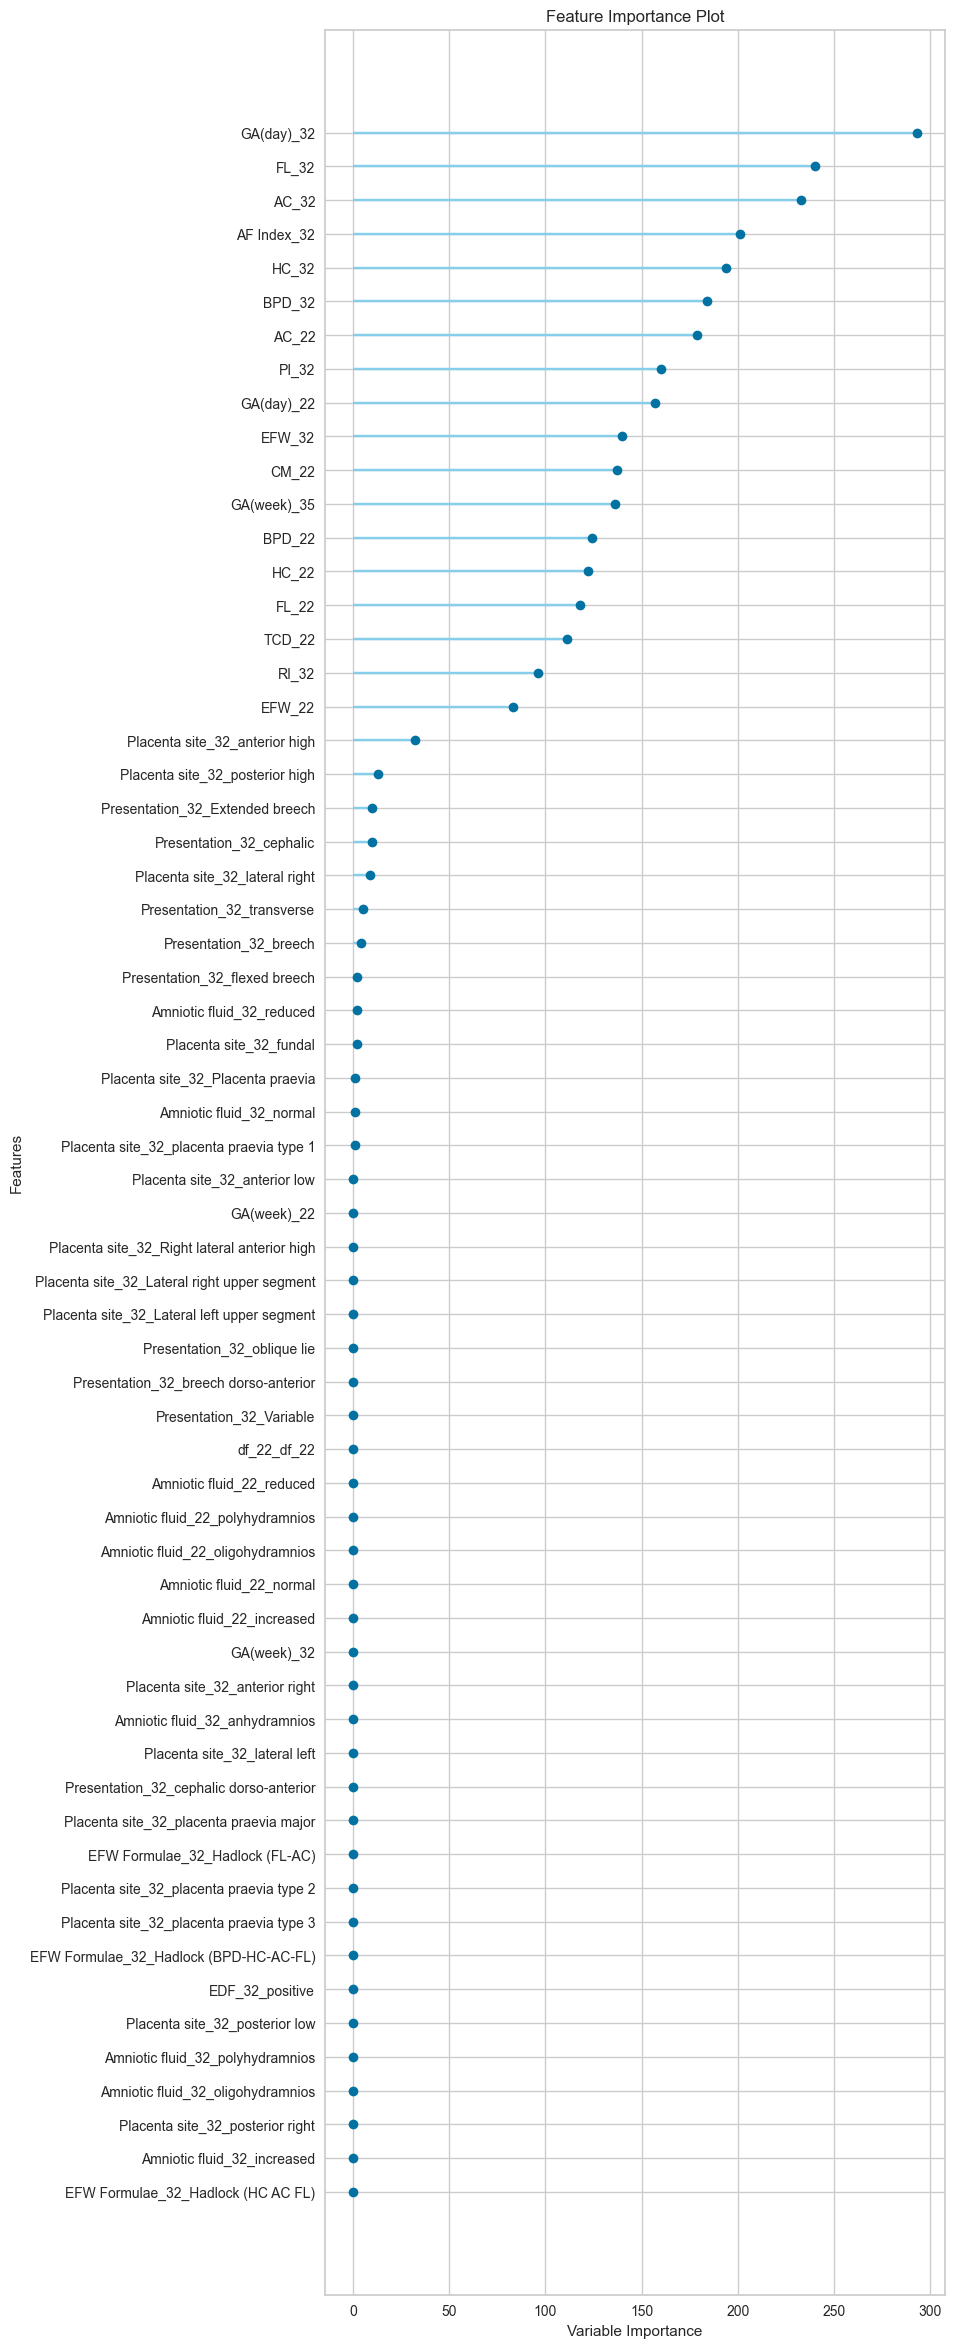

In [161]:
#GA(day)_32, FL_32, AC_32, AF Index_32, HC_32, BPD_32, AC_22, PI_32, GA(day)_22, EFW_32, CM_22, GA(week)_35, BPD_22, HC_22, FL_22, TCD_22, RI_32, EFW_22)
plot_model(model_, 'feature_all')

In [290]:
df_22_32_35_train_90.columns

Index(['BPD_22', 'HC_22', 'TCD_22', 'AC_22', 'CM_22', 'FL_22', 'EFW_22',
       'Amniotic fluid_22', 'GA(day)_22', 'GA(week)_22', 'df_22', 'BPD_32',
       'HC_32', 'AC_32', 'FL_32', 'EFW_32', 'Presentation_32',
       'Placenta site_32', 'AF Index_32', 'Amniotic fluid_32', 'PI_32',
       'RI_32', 'EDF_32', 'EFW Formulae_32', 'GA(day)_32', 'GA(week)_32',
       'GA(week)_35', 'EFW_35'],
      dtype='object')

In [164]:
col_test_22_32_35 = ['GA(day)_32', 'FL_32', 'AC_32', 'AF Index_32', 'HC_32', 'BPD_32', 'AC_22', 'PI_32', 'GA(day)_22', 'EFW_32', 'CM_22', 'GA(week)_35', 'BPD_22', 'HC_22', 'FL_22', 'TCD_22', 'RI_32', 'EFW_22']
df_result_22_32_35, cols_to_use_22_32_35 = filter_feature(df_22_32_35_train_90, col_test_22_32_35, 'EFW_35')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,207.4203,70459.8491,265.3687,0.5437,0.0963,0.0761,0.0630
rf,Random Forest Regressor,208.0946,72271.7635,268.7549,0.5324,0.0976,0.0766,0.7690
et,Extra Trees Regressor,203.8304,73949.9929,271.8303,0.5214,0.0985,0.0749,0.4200
gbr,Gradient Boosting Regressor,220.4772,76816.5658,277.1075,0.5030,0.1011,0.0814,0.2840
lasso,Lasso Regression,225.0014,80596.7250,283.8363,0.4783,0.1038,0.0831,0.0090
ridge,Ridge Regression,224.9962,80628.9852,283.8922,0.4781,0.1038,0.0831,0.0070
lr,Linear Regression,225.0723,80635.3898,283.9051,0.4780,0.1038,0.0831,0.0200
lar,Least Angle Regression,225.0723,80635.3912,283.9051,0.4780,0.1038,0.0831,0.0100
br,Bayesian Ridge,224.9987,80642.6761,283.9157,0.4780,0.1038,0.0831,0.0080
en,Elastic Net,229.5475,83613.3070,289.1052,0.4590,0.1059,0.0849,0.0110


DONE!


In [165]:
df_result_22_32_35 
#the results appear due to some duplicates appears between 22 and 32. 
#I am more towards previous one that has more unique patients datasets.

,Model,R2,RMSE,Feature Removed,Help?,Comments
0,Light Gradient Boosting Machine,0.5453,264.9279,None,None,Threshold
1,Light Gradient Boosting Machine,0.5008,277.6277,GA(day)_32,True,Compare
2,Light Gradient Boosting Machine,0.5390,266.7762,FL_32,False,Compare
3,Light Gradient Boosting Machine,0.5370,267.3474,AC_32,False,Compare
4,Light Gradient Boosting Machine,0.5422,265.7547,AF Index_32,False,Compare
5,Light Gradient Boosting Machine,0.5420,265.9406,HC_32,False,Compare
6,Light Gradient Boosting Machine,0.5397,266.5844,BPD_32,False,Compare
7,Light Gradient Boosting Machine,0.5442,265.2475,AC_22,False,Compare
8,Light Gradient Boosting Machine,0.5394,266.6462,PI_32,False,Compare
9,Light Gradient Boosting Machine,0.5372,267.2732,GA(day)_22,False,Compare


In [166]:
print(cols_to_use_22_32_35)

['GA(day)_32', 'GA(week)_35']


# Planning
 
1. Split into 3df, try to identify usable data (here means identify patient that has 3 records of different wk) regardless of missing value first
- Visualize each wk
- Check feature relationships 
- Handling missing value
- Feature Engineer some stuff if possible
- Try pycaret

19/11/2021
- Summarize those stuff